In [1]:
import xarray
import numpy as np
from matplotlib import pyplot as plt

import os

In [2]:
adcp_datapath = '/home/cha674/Work/IN2024_V04/'
#adcp_filename = 'os150nb.nc'
adcp_filename = 'os75nb.nc'

adcp_dataset = xarray.open_dataset(os.path.join(adcp_datapath,adcp_filename)).load()
#adcp_dataset.close()


In [3]:
adcp_dataset.time.min()

<xarray.DataArray 'time' ()>
array('2024-06-13T19:48:11.000000000', dtype='datetime64[ns]')

In [4]:
ctd_datapath = '/run/user/336728/gvfs/smb-share:server=data.investigator.csiro.au,share=voyages/in2024_v04/ctd/processing/in2024_v04/cap/cappro/avg'
ctd_files =  []

ctd_lats   = []
ctd_lons   = []
ctd_times   = []



list_dir = os.listdir(ctd_datapath)

for i_file in list_dir:
    if os.path.isfile(os.path.join(ctd_datapath,i_file) ) and i_file.endswith('.nc'):
        ctd_files.append(i_file)
        
        current_ctd_file = xarray.open_dataset(os.path.join(ctd_datapath,i_file))
        
        ctd_lons.append(current_ctd_file['longitude'].values)
        ctd_lats.append(current_ctd_file['latitude'].values)
        ctd_times.append(current_ctd_file['time'].values)
        
ctd_times = np.asarray(ctd_times)
ctd_lons  = np.asarray(ctd_lons)
ctd_lats  = np.asarray(ctd_lats)


In [5]:
bathy_file = '/run/user/336728/gvfs/smb-share:server=data.investigator.csiro.au,share=science-team/Solitary_Island_Canyon_High_Res_Bathy.nc'
bathy_dataset = xarray.open_dataset(bathy_file)

In [6]:
bathy_dataset

<xarray.Dataset>
Dimensions:  (lat: 1417, lon: 1607)
Coordinates:
  * lat      (lat) float64 -30.41 -30.41 -30.41 -30.41 ... -29.7 -29.7 -29.7
  * lon      (lon) float64 153.3 153.3 153.3 153.3 ... 154.1 154.1 154.1 154.1
Data variables:
    crs      |S1 ...
    Band1    (lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.4.0, released 2021/11/04
    history:      Wed Jun 12 11:38:37 2024: GDAL CreateCopy( /mnt/ClipZipShip...

NameError: name 'dasd' is not defined

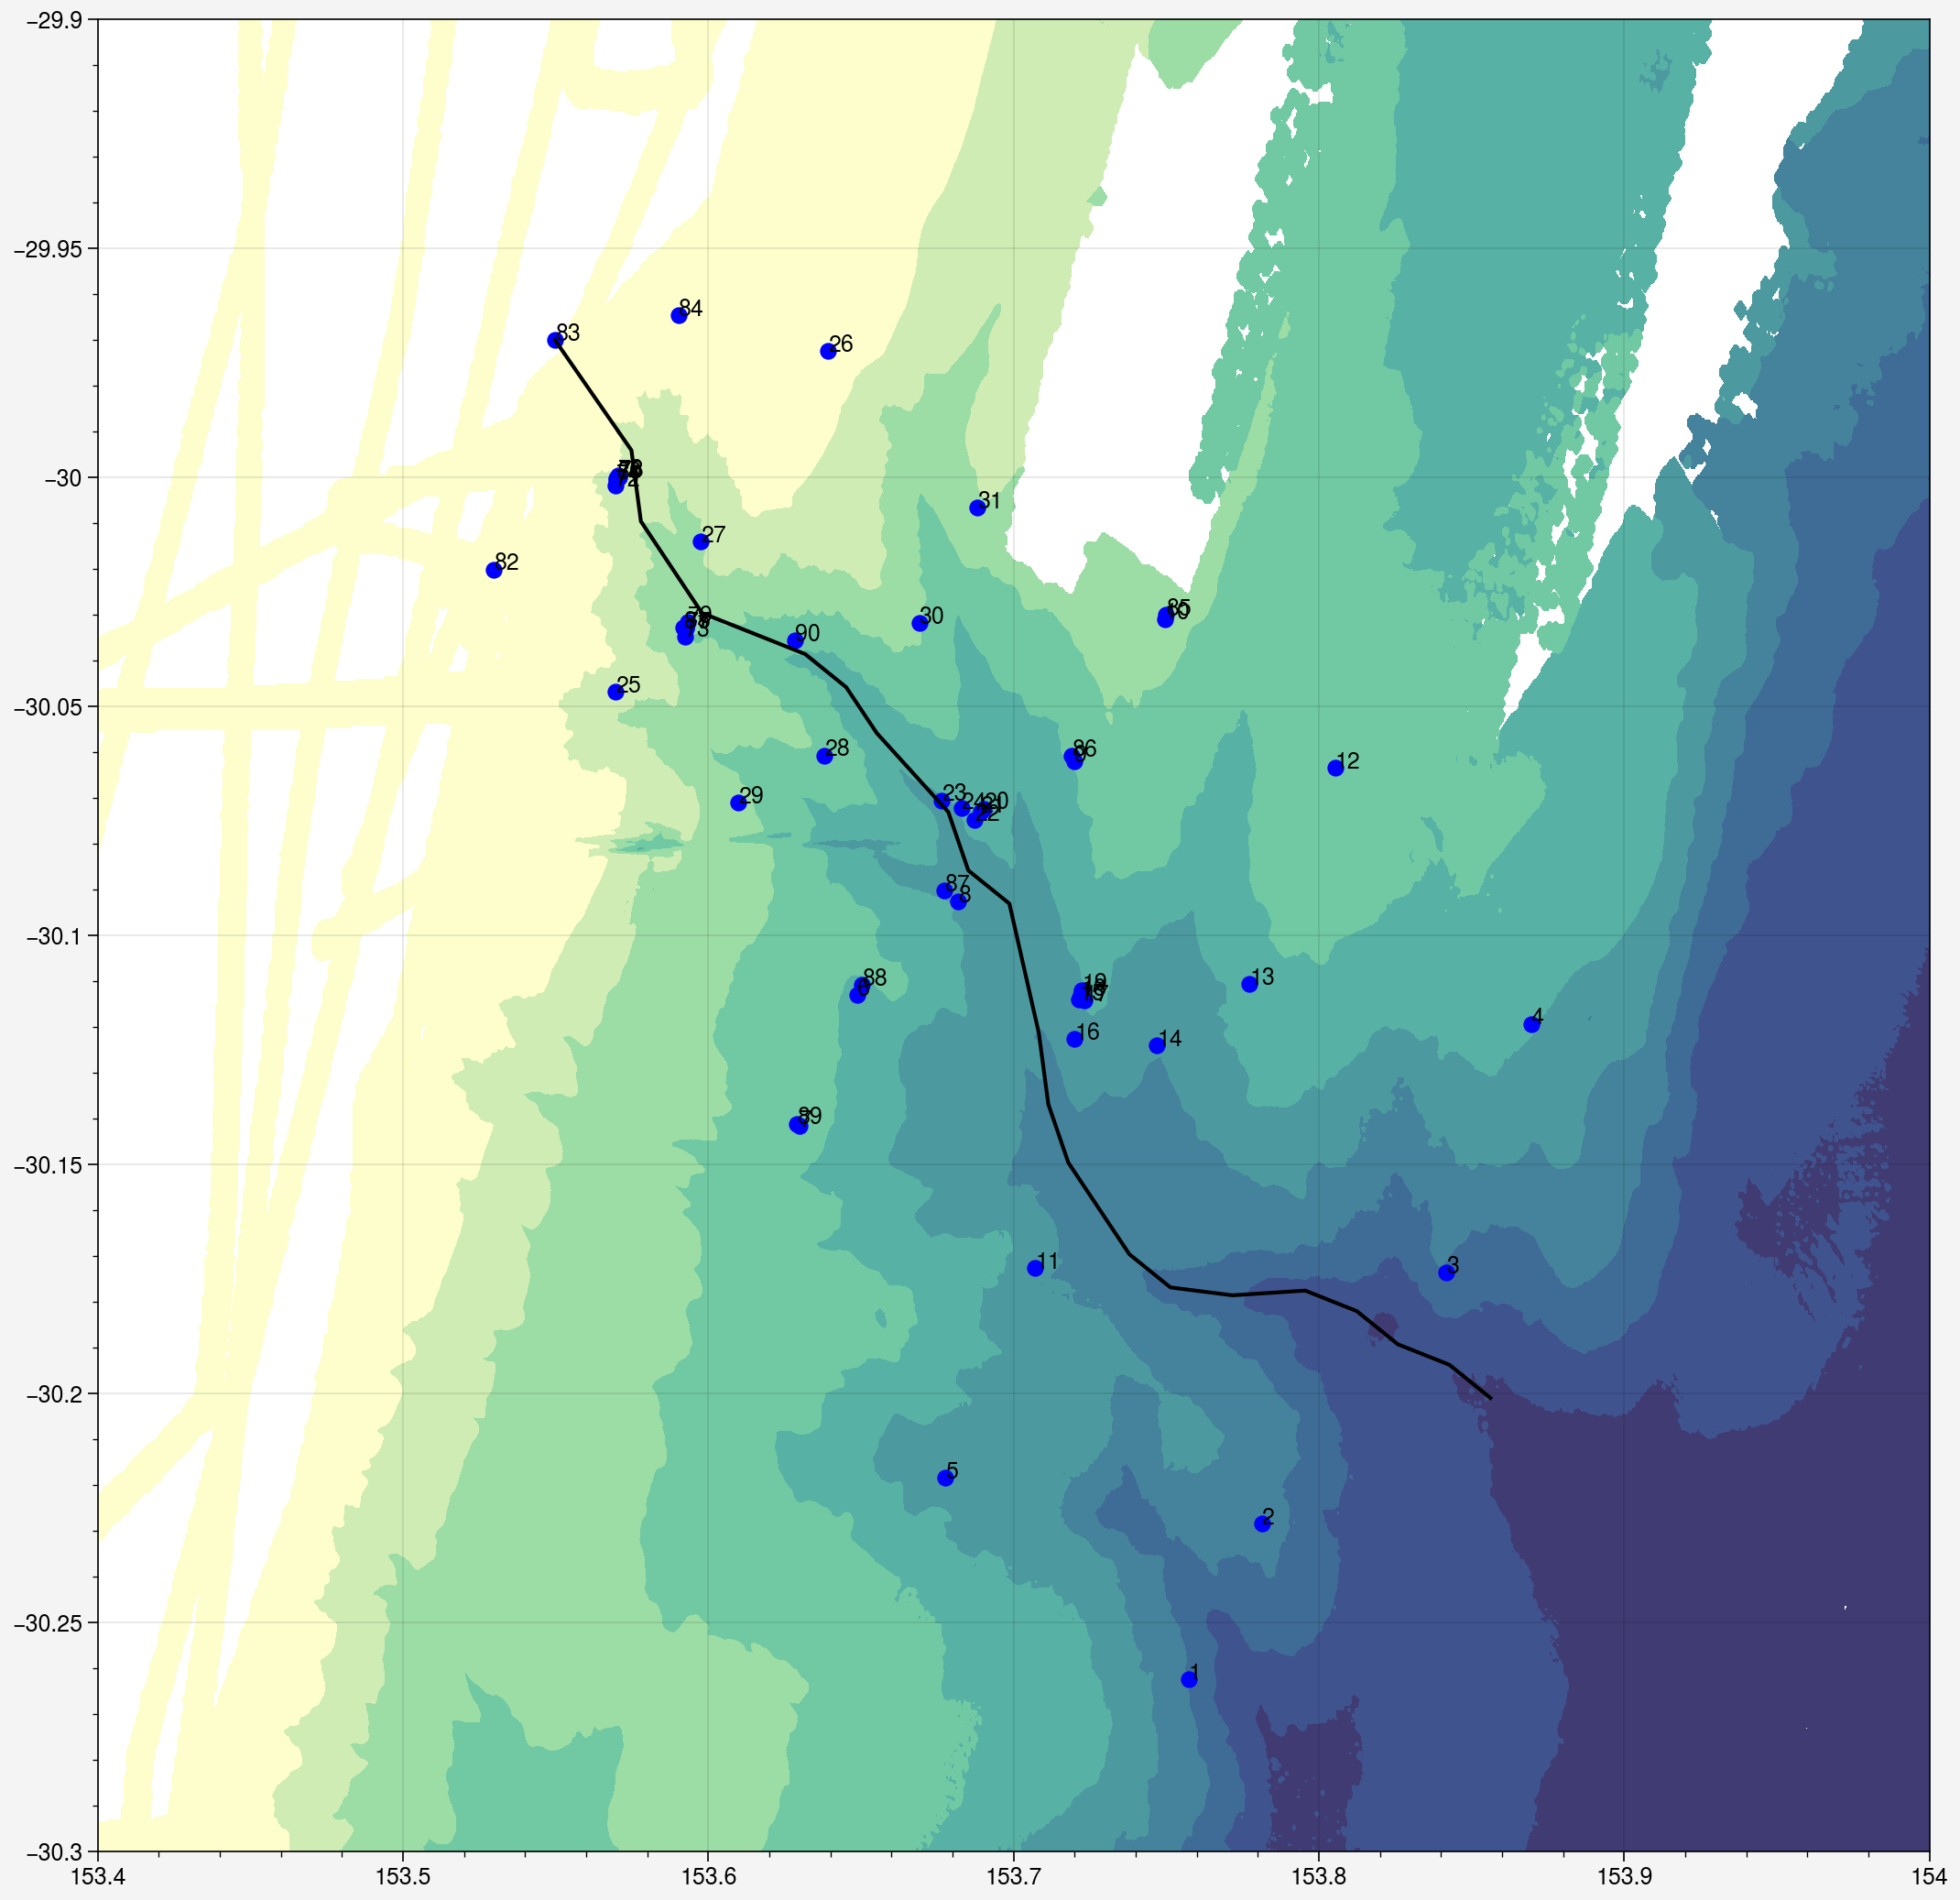

In [45]:
import proplot
#proplot.rc.reso = 'hi'


# Zooming in on continents
fig = proplot.figure(refwidth=10)
ax = fig.subplots(ncols=1,nrows=1) #, proj='cyl', proj_kw={'lon_0': 150})
cs = ax[0].contourf(bathy_dataset['lon'].values,bathy_dataset['lat'].values,bathy_dataset['Band1'].values,levels=np.arange(-6000,1,500),cmap='deep_r')

ctd_counter =1
for i_ctd in range(0,len(ctd_files)):
    if ctd_lats[i_ctd]>-30.4 and  ctd_lats[i_ctd]<-29.7 and ctd_lons[i_ctd]>153.4 and ctd_lons[i_ctd]<154:
        ax[0].scatter(ctd_lons[i_ctd],ctd_lats[i_ctd],c='blue')
        ax[0].annotate(i_ctd, (ctd_lons[i_ctd],ctd_lats[i_ctd]), xytext=None, xycoords='data')

    ctd_counter = ctd_counter+1

ax[0].set_ylim((-30.3, -29.9))
ax[0].set_xlim((153.4, 154))


delta_lon = 0.01
delta_lat = -0.01


#Shift line away from flat shelf region
diagonal_line_lat = np.asarray([-30.0,-29.92]) + 3.0*delta_lat
diagonal_line_lon = np.asarray([153.5,153.6])  + 3.0*delta_lon


canyon_min_lat = [ ctd_lats[83][0] ]
canyon_min_lon = [ ctd_lons[83][0] ]
depth_min      = [ -100.0 ] # bathy_dataset['Band1'].sel(lat=canyon_min_lat[0] , lon=canyon_min_lon[0],method='nearest').values]
depth_min 

for i_line in range(0,25):
    lat_segment = xarray.DataArray(np.linspace(diagonal_line_lat[0],diagonal_line_lat[1],30), dims="z")
    lon_segment = xarray.DataArray(np.linspace(diagonal_line_lon[0],diagonal_line_lon[1],30), dims="z")

    bathy_profile = bathy_dataset.interp(lat=lat_segment, lon=lon_segment)

    
    
    min_bathy_profile = np.argmin(bathy_profile['Band1'].values)
    depth_min.append(bathy_profile['Band1'].min().values.astype('float32'))
    canyon_min_lat.append(lat_segment[min_bathy_profile])
    canyon_min_lon.append(lon_segment[min_bathy_profile])

    #ax[0].plot(diagonal_line_lon,diagonal_line_lat)
    diagonal_line_lon = diagonal_line_lon + delta_lon
    diagonal_line_lat = diagonal_line_lat + delta_lat

canyon_min_lon = np.asarray(canyon_min_lon)
canyon_min_lat = np.asarray(canyon_min_lat)
depth_min = np.asarray(depth_min)

idx_kink = np.nonzero(np.diff(canyon_min_lon)<0)[0]

for i_bad_points in idx_kink:
    canyon_min_lon[i_bad_points+1] = 0.5*(canyon_min_lon[i_bad_points+2] + canyon_min_lon[i_bad_points])
    canyon_min_lat[i_bad_points+1] = 0.5*(canyon_min_lat[i_bad_points+2] + canyon_min_lat[i_bad_points])

ax[0].plot(canyon_min_lon,canyon_min_lat,'k')
#ax[0].scatter(canyon_min_lon[idx_kink+1],canyon_min_lat[idx_kink+1],c='r')

dasd

#ax[0].format(latlim=(-30.4, -29.7), lonlim=(153.4, 154),land='True',landcolor='grey',lonlabels='left')

ctd_index_to_plot = [25,26,27]
ctd_index_to_plot = [29,28,30,31]
ctd_index_to_plot  = [9,10,11,12,13,14,16]
#ctd_index_to_plot = [7,6,8,9,10]
#ctd_index_to_plot = [1,2,3,4,5]
#ctd_index_to_plot = [2,3,4,5]
ctd_index_to_plot = range(1,32) #len(ctd_files))
#ctd_index_to_plot = np.arange(1,len(ctd_files))
for i_ctd in ctd_index_to_plot:
    i_file_name = ctd_files[i_ctd]
    ax[0].annotate(i_ctd, (ctd_lons[i_ctd],ctd_lats[i_ctd]), xytext=None, xycoords='data')
    ctd_counter = ctd_counter+1
#plt.plot(lon_segment[::-1],lat_segment[::-1])   
fig.colorbar(cs)

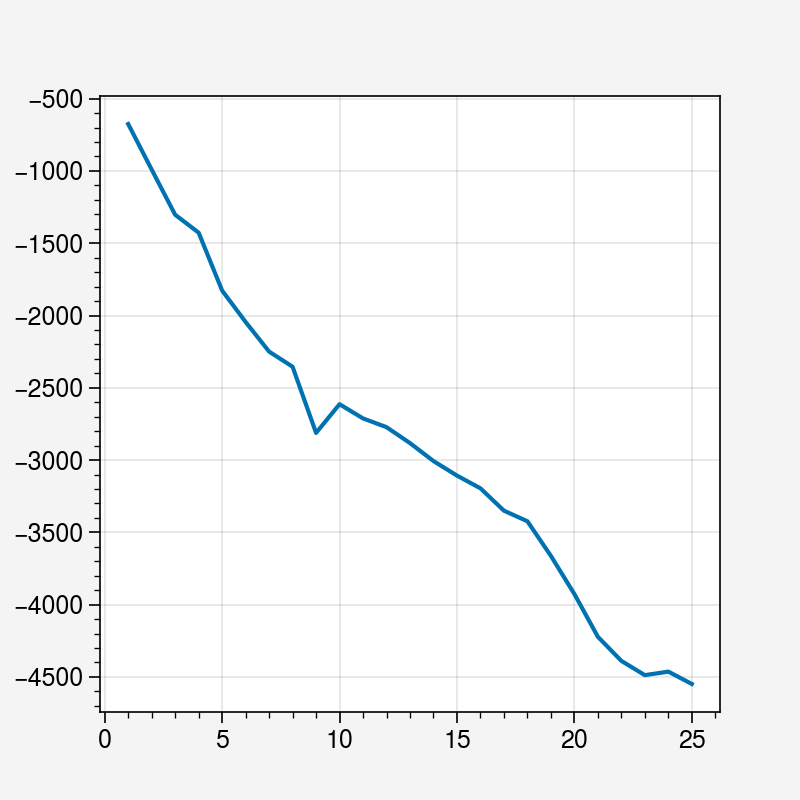

In [9]:
plt.plot(depth_min)

In [10]:
def distance(s_lat, s_lng, e_lat, e_lng):

   # Approximate radius of earth in km
   R = 6373.0e3

   s_lat = s_lat*np.pi/180.0
   s_lng = np.deg2rad(s_lng)
   e_lat = np.deg2rad(e_lat)
   e_lng = np.deg2rad(e_lng)

   d = np.sin((e_lat - s_lat)/2)**2 + np.cos(s_lat)*np.cos(e_lat) * np.sin((e_lng - s_lng)/2)**2

   return 2 * R * np.arcsin(np.sqrt(d))

In [126]:
import gsw as TEOS_10

distance_threshold = 2.0e3
pressure_max_length = 0


for i_point in range(0,canyon_min_lon.size):

    distance_to_ctd = distance(ctd_lats, ctd_lons, canyon_min_lat[i_point], canyon_min_lon[i_point])
    idx_to_get = np.nonzero(distance_to_ctd<distance_threshold)[0]

    for i_ctd_to_get in idx_to_get:
        ctd_files_to_get = ctd_files[i_ctd_to_get]
        ctd_dataset = xarray.open_dataset(os.path.join(ctd_datapath,ctd_files_to_get))
        pressure_length = ctd_dataset['pressure'].size

        if pressure_length > pressure_max_length:
            pressure_max_length = pressure_length
            pressure_thalweg = ctd_dataset['pressure'].values
        ctd_dataset.close()
                         
#END for
CT_thalweg = np.zeros([len(canyon_min_lon),pressure_max_length],dtype='float32')
SA_thalweg = np.zeros([len(canyon_min_lon),pressure_max_length],dtype='float32')
sigma0_thalweg = np.zeros([len(canyon_min_lon),pressure_max_length],dtype='float32')

for i_point in range(0,canyon_min_lon.size):

    distance_to_ctd = distance(ctd_lats, ctd_lons, canyon_min_lat[i_point], canyon_min_lon[i_point])
    idx_to_get = np.nonzero(distance_to_ctd<distance_threshold)[0]

    n_ctds = 0 
    
    pressure_count = np.zeros([pressure_max_length],dtype='float32')

    for i_ctd_to_get in idx_to_get:
        ctd_files_to_get = ctd_files[i_ctd_to_get]
        ctd_dataset = xarray.open_dataset(os.path.join(ctd_datapath,ctd_files_to_get))

        latitude_cast = ctd_dataset['latitude'].squeeze().values
        longitude_cast = ctd_dataset['longitude'].squeeze().values

        pressure_length = ctd_dataset['pressure'].size
        temperature_cast = ctd_dataset['temperature'].squeeze().values
        salinity_cast = ctd_dataset['salinity'].squeeze().values
        pressure_cast = ctd_dataset['pressure'].squeeze().values


        absolute_salinity        = TEOS_10.SA_from_SP(salinity_cast,pressure_cast,longitude_cast,latitude_cast)
        conservative_temperature = TEOS_10.CT_from_t(absolute_salinity,temperature_cast,pressure_cast) 
        sigma0                   = TEOS_10.sigma0(absolute_salinity,temperature_cast)
        
        CT_thalweg[i_point,0:pressure_length] = CT_thalweg[i_point,0:pressure_length] + conservative_temperature
        SA_thalweg[i_point,0:pressure_length] = SA_thalweg[i_point,0:pressure_length] + absolute_salinity
        sigma0_thalweg[i_point,0:pressure_length] = sigma0_thalweg[i_point,0:pressure_length] + sigma0

        pressure_count[0:pressure_length] = pressure_count[0:pressure_length] + np.ones([pressure_length])

        ctd_dataset.close()
        #n_ctds = n_ctds+1
        ##if n_ctd>10:
        ##    dsad
    pressure_count_mask = pressure_count<1
    pressure_count[pressure_count_mask] = 1.0
    
    CT_thalweg[i_point,:] = CT_thalweg[i_point,:]/pressure_count
    SA_thalweg[i_point,:] = SA_thalweg[i_point,:]/pressure_count
    sigma0_thalweg[i_point,:] = sigma0_thalweg[i_point,:]/pressure_count

temperature_thalweg_zero_mask = CT_thalweg<=0.1
CT_thalweg[temperature_thalweg_zero_mask] = np.nan
SA_thalweg[temperature_thalweg_zero_mask] = np.nan
sigma0_thalweg[temperature_thalweg_zero_mask] = np.nan

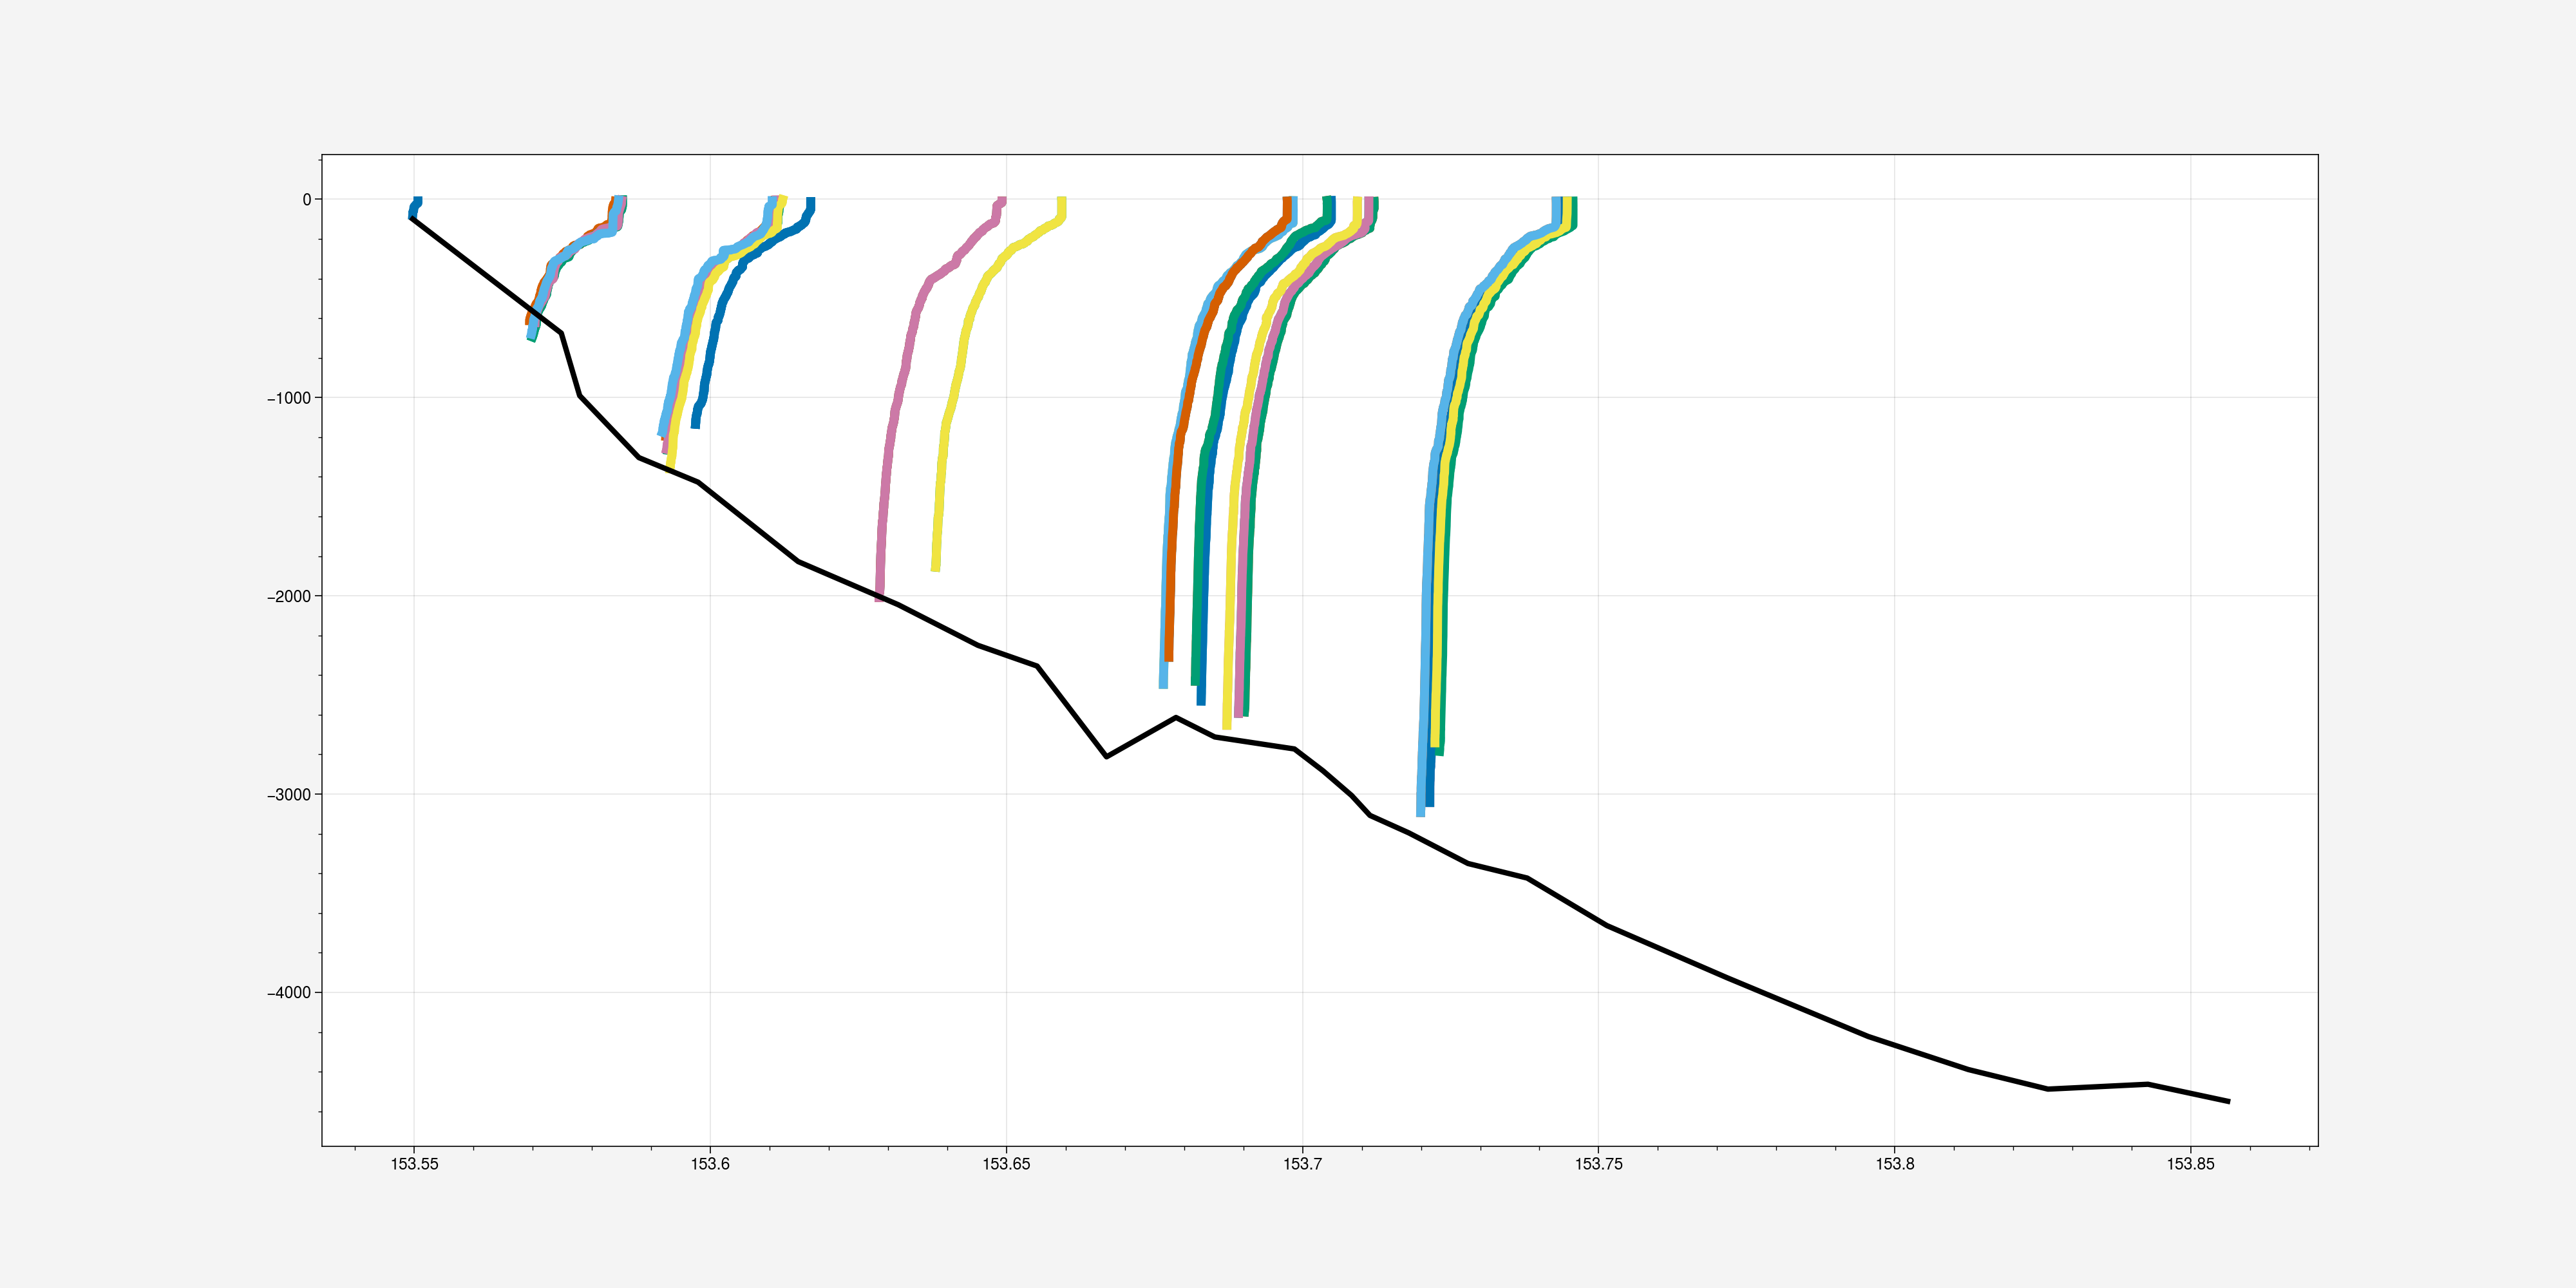

In [123]:
import gsw as TEOS_10

distance_threshold = 2.0e3

CT_thalweg = []
SA_thalweg = []
presure_thalweg = []

lat_thalweg = []
lon_thalweg = []


fig = plt.figure(1,figsize=(20,10))
ax  = fig.add_subplot(1,1,1)

for i_point in range(0,canyon_min_lon.size):

    distance_to_ctd = distance(ctd_lats, ctd_lons, canyon_min_lat[i_point], canyon_min_lon[i_point])
    idx_to_get = np.nonzero(distance_to_ctd<distance_threshold)[0]

    n_ctds = 0 
    
    for i_ctd_to_get in idx_to_get:
        
        ctd_files_to_get = ctd_files[i_ctd_to_get]
        ctd_dataset = xarray.open_dataset(os.path.join(ctd_datapath,ctd_files_to_get))

        latitude_cast = ctd_dataset['latitude'].squeeze().values
        longitude_cast = ctd_dataset['longitude'].squeeze().values

        pressure_length = ctd_dataset['pressure'].size

        
        temperature_cast = ctd_dataset['temperature'].squeeze().values
        salinity_cast = ctd_dataset['salinity'].squeeze().values
        pressure_cast = ctd_dataset['pressure'].squeeze().values
        
        presure_thalweg.append(pressure_cast.copy())
        #print(presure_thalweg)
        absolute_salinity        = TEOS_10.SA_from_SP(salinity_cast,pressure_cast,longitude_cast,latitude_cast)
        conservative_temperature = TEOS_10.CT_from_t(absolute_salinity,temperature_cast,pressure_cast) 


        ax.plot(0.001*(conservative_temperature-np.min(conservative_temperature))+longitude_cast,-pressure_cast,linewidth=5.0)

        #CT_thalweg.append(conservative_temperature)
        #SA_thalweg.append(absolute_salinity)


        #lat_thalweg.append(latitude_cast.copy())
        #lon_thalweg.append(longitude_cast.copy())

        ctd_dataset.close()
    #END for i_ctd
#END for i_point
ax.plot(canyon_min_lon,depth_min,color='k',linewidth=3.0)


In [120]:
len(pressure_thalweg)

3085

ValueError: x and y must have same first dimension, but have shapes (74,) and (1,)

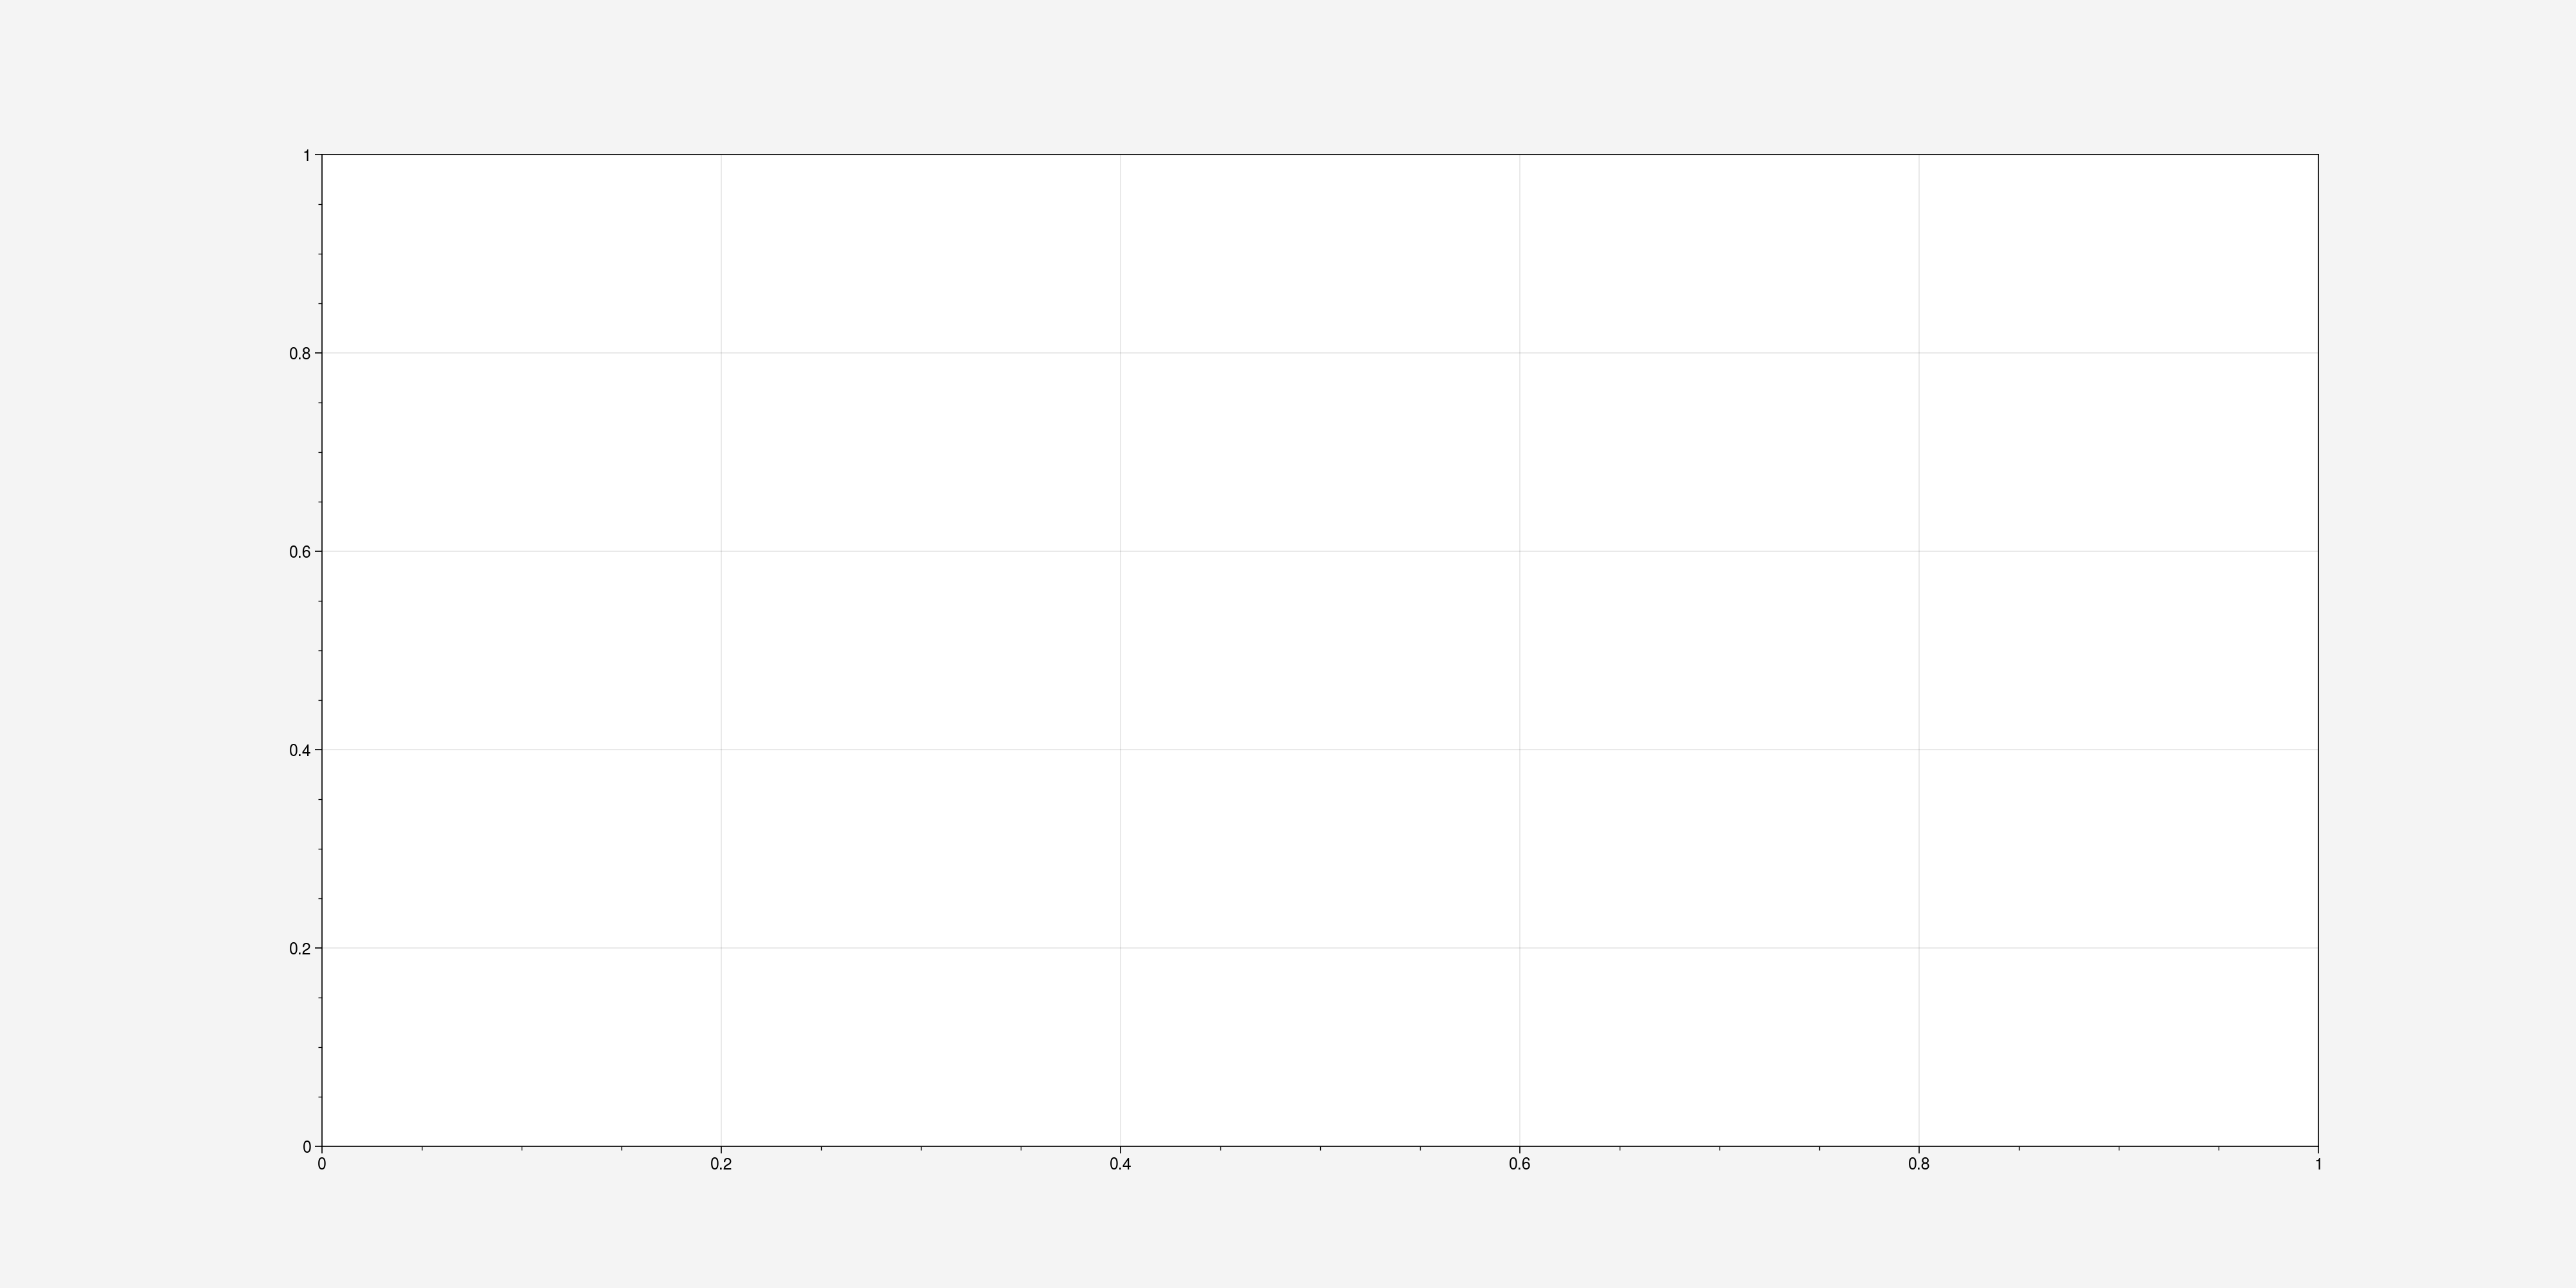

In [113]:
n_casts = len(CT_thalweg)

fig = plt.figure(1,figsize=(20,10))
ax  = fig.add_subplot(1,1,1)
for i_cast in range(0,n_casts):
    
    #temperature_cast = CT_thalweg[i_cast]
    #pressure_cast    = pressure_thalweg[i_cast]

    lon_cast = lon_thalweg[i_cast]
    
    ax.plot(0.001*(CT_thalweg[i_cast]-np.min(CT_thalweg[i_cast]))+lon_cast,-pressure_thalweg[i_cast],linewidth=5.0)

    

In [82]:
pressure_profile

9.259262561798096

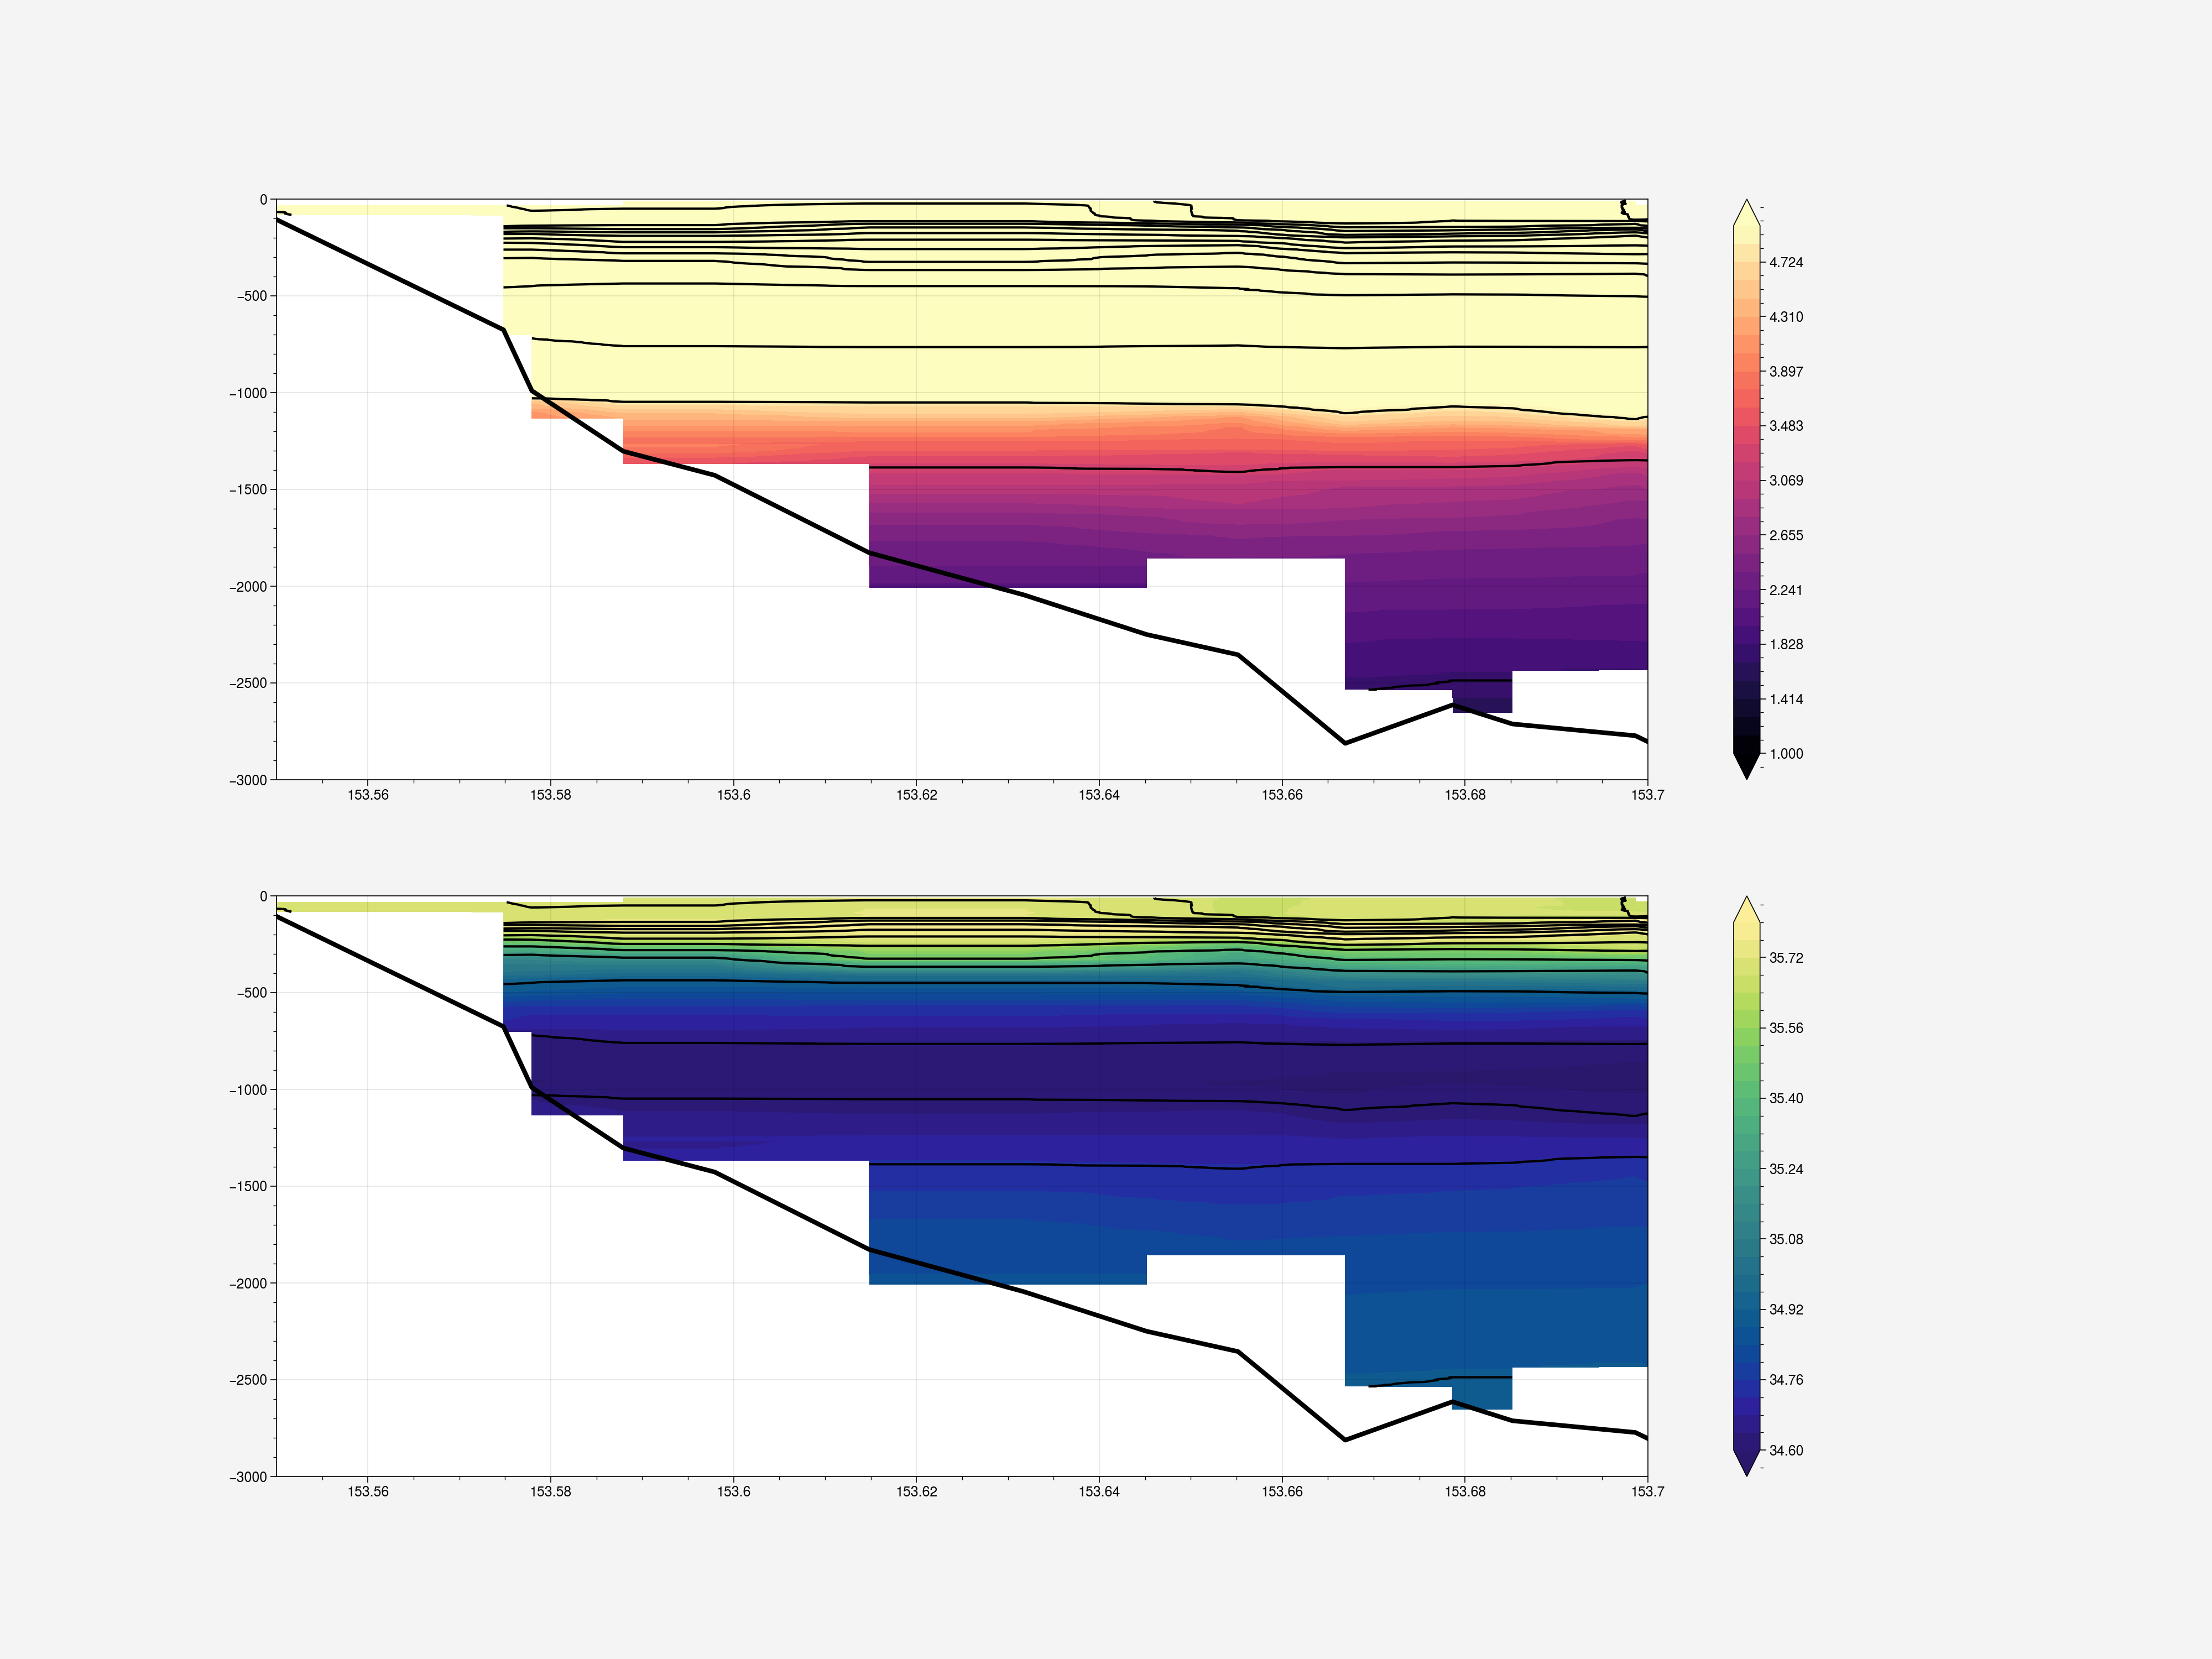

In [140]:
fig = plt.figure(1,figsize=(20,15))
ax  = fig.add_subplot(2,1,1)
cs_temp = ax.contourf(canyon_min_lon,-pressure_thalweg,CT_thalweg.T,np.linspace(1,5,30),cmap='magma',extend='both') #,cmap='magma',)
ax.contour(canyon_min_lon,-pressure_thalweg,sigma0_thalweg.T,np.arange(20,35.1,0.25),colors='k') #,extend='both') #,cmap='magma',)
ax.plot(canyon_min_lon,depth_min,color='k',linewidth=3.0)
ax.set_xlim([153.55,153.7])
ax.set_ylim([-3000,0])

fig.colorbar(cs_temp,ax=ax)


ax  = fig.add_subplot(2,1,2)
cs_salt = ax.contourf(canyon_min_lon,-pressure_thalweg,SA_thalweg.T,30,cmap='Haline',extend='both') #,cmap='magma',)
ax.contour(canyon_min_lon,-pressure_thalweg,sigma0_thalweg.T,np.arange(20,35.1,0.25),colors='k') #,extend='both') #,cmap='magma',)
ax.plot(canyon_min_lon,depth_min,color='k',linewidth=3.0)
ax.set_xlim([153.55,153.7])
ax.set_ylim([-3000,0])

fig.colorbar(cs_salt,ax=ax)

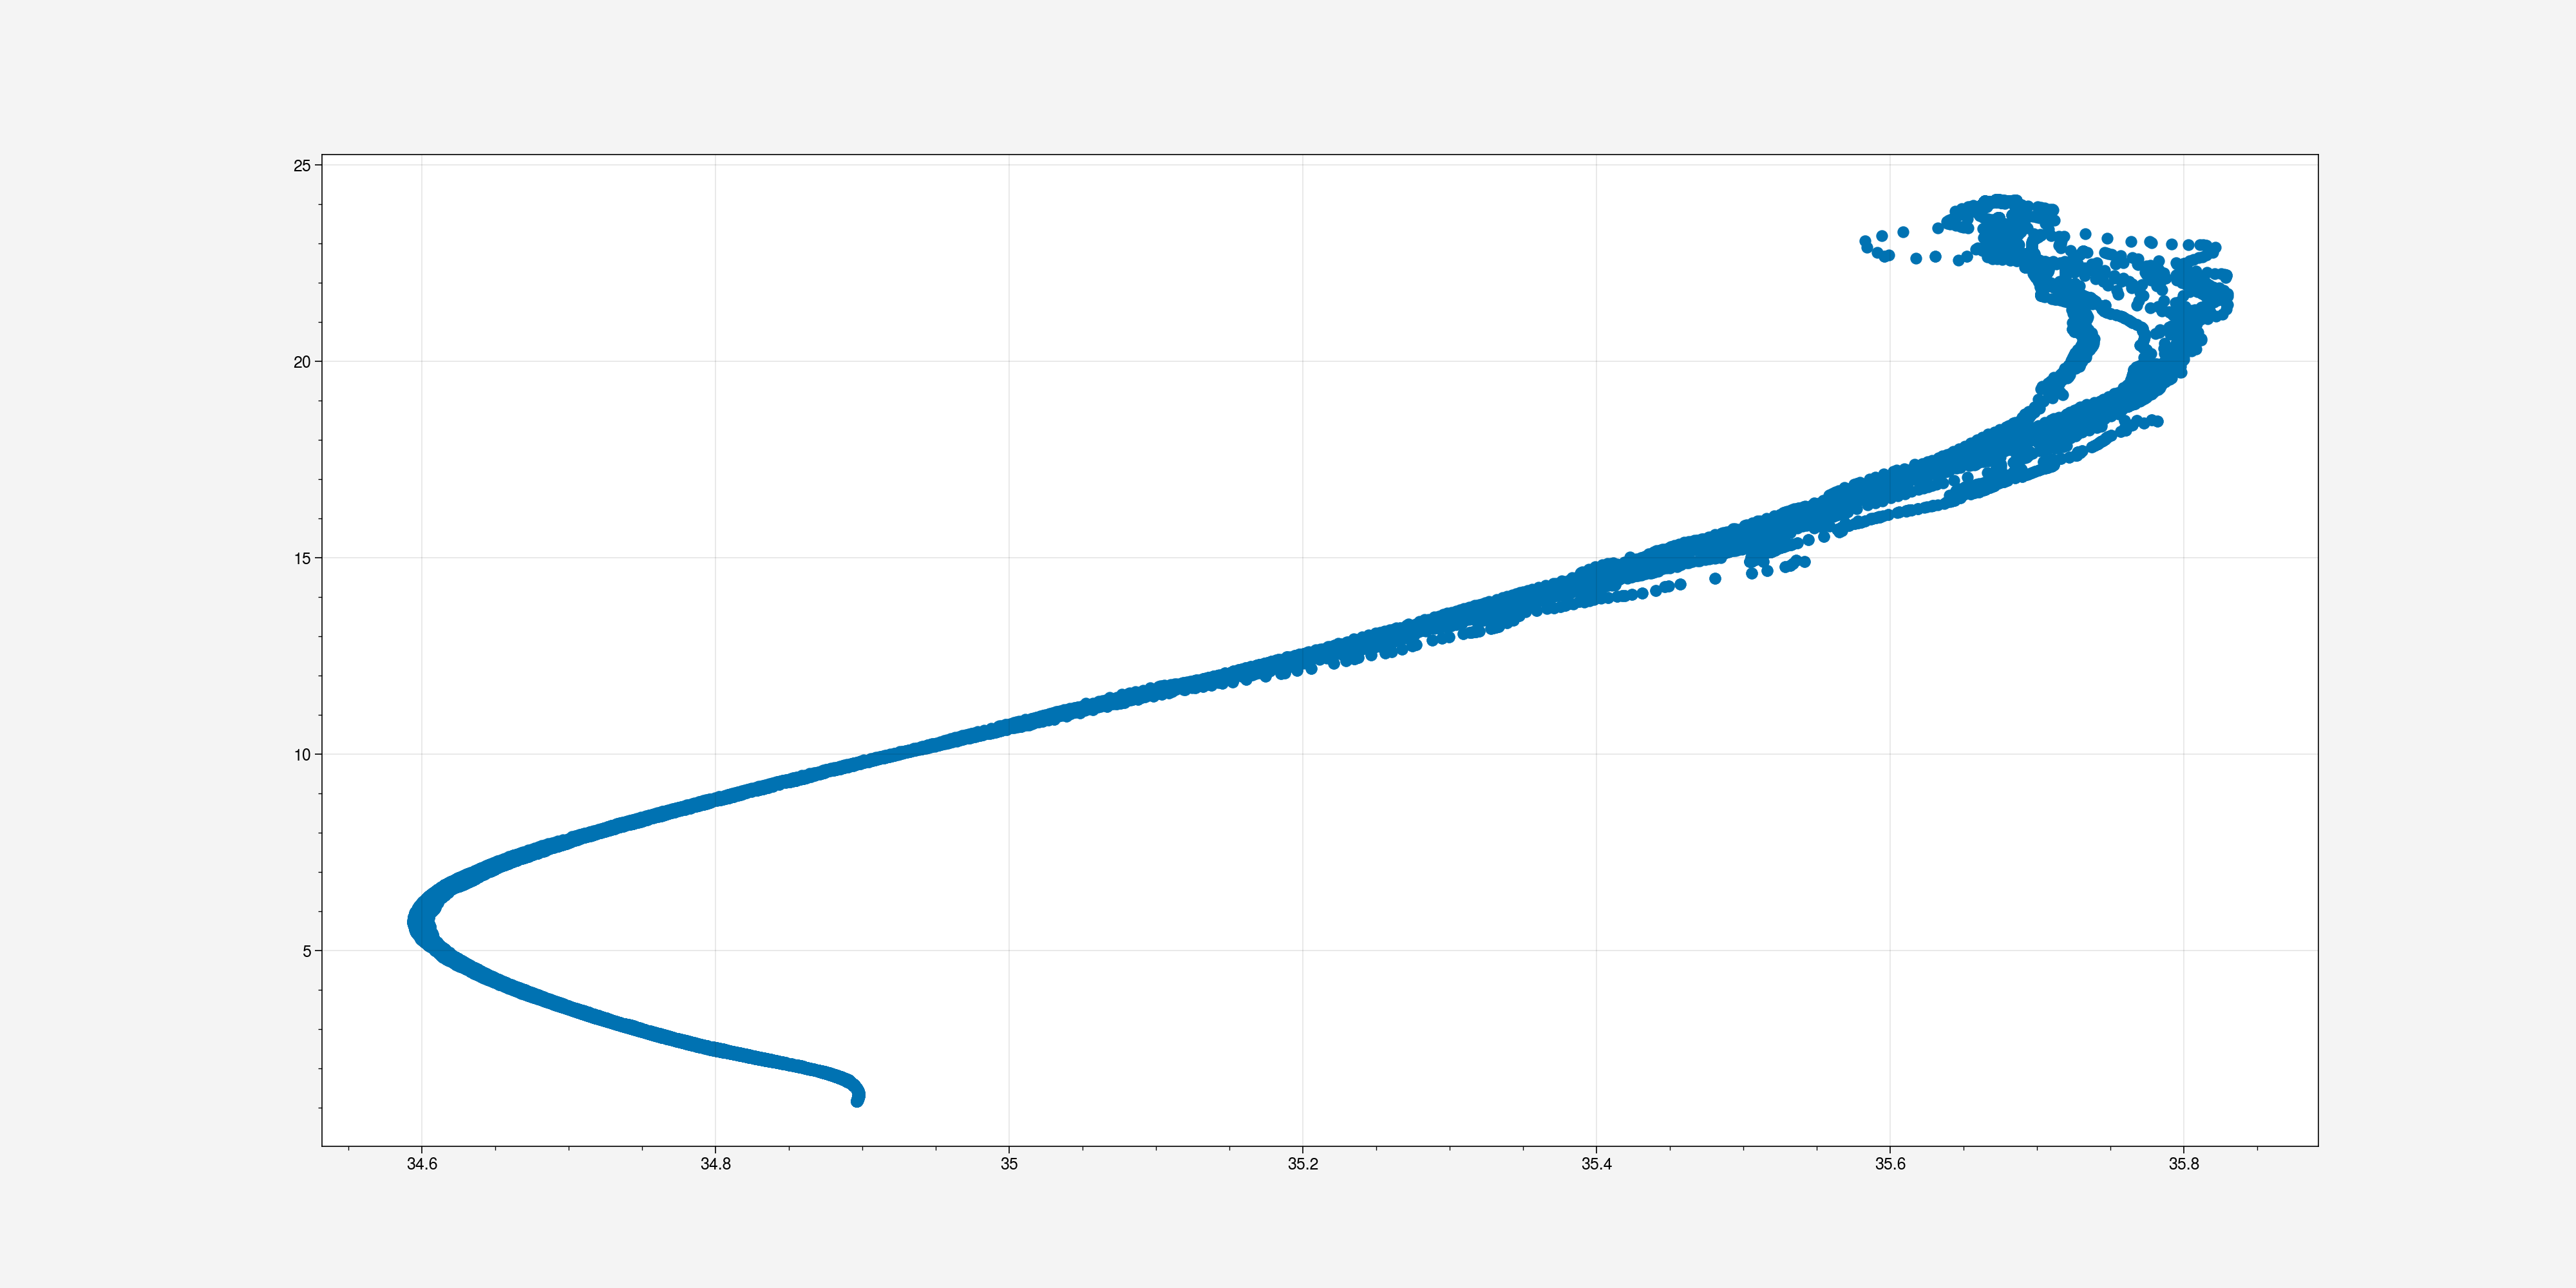

In [139]:
plt.figure(1,figsize=(20,10))
plt.scatter(SA_thalweg,CT_thalweg,c=)

In [51]:
def get_adcp_data(cast_path, cast):
    from scipy import io as sio
    """
    Load ADCP data from a MAT file for a given cast number.
    
    Parameters:
    cast (int): The cast number to load.
    
    Returns:
    dict: The extracted data from the MAT file.
    """
    file = f'{cast:03d}.mat'
    pathF = os.path.join(cast_path, 'processed', file)
    mat_data = sio.loadmat(pathF, simplify_cells=True)
    return mat_data['dr']
    

In [59]:
def get_valid_casts(castpath, castset,last_cast):
    """
    Retrieve valid ADCP casts data.
    
    Parameters:
    last_cast (int): The last cast number to check.
    
    Returns:
    dict: A dictionary with valid casts data.
    """

    if castset == 'all':

        valid_casts = {}
        for cast in range(1, last_cast + 1):
            try:
                dr = get_adcp_data(castpath,cast)
                if dr['lon'] != 0 and cast != 1:
                    valid_casts[f'Cast{cast:03d}'] = dr
            except (FileNotFoundError, KeyError):
                print(cast) # Print invalid Casts if you like
        return valid_casts

    else:

        valid_casts = {}
        for cast in castset:
            try:
                dr = get_adcp_data(castpath,cast)
                if dr['lon'] != 0 and cast != 1:
                    valid_casts[f'Cast{cast:03d}'] = dr
            except (FileNotFoundError, KeyError):
                print(cast) # Print invalid Casts if you like
        return valid_casts

In [69]:
def process_casts(valid_casts):
    """
    Process the valid casts into interpolated DataFrames.
    
    Parameters:
    valid_casts (dict): The valid casts data.
    
    Returns:
    dict: A dictionary of interpolated DataFrames for each cast.
    """
    Cdata = {}
    import pandas
    for cast, data in valid_casts.items():
        df_data = {
            'z': data['z'],
            'u': data['u'],
            'v': data['v']
        }
        Cdata[cast] = pandas.DataFrame(df_data)

    big_dep = []
    # max depth is 4408m
    Cdata_interpolated = {}
    full_depth_range = np.arange(0, 4500, 2)  # Define the full depth range
    for cast, df in Cdata.items():
        z = df['z']
        u = df['u']
        v = df['v']

        # Find the maximum depth with valid u and v measurements
        max_depth = max(z)
        big_dep.append(max_depth)

        # Define the interpolation depths, only up to the max_depth
        interpolated_z = np.arange(2, max_depth + 1, 2)
        interpolated_u = np.interp(interpolated_z, z, u, left=np.nan, right=np.nan)
        interpolated_v = np.interp(interpolated_z, z, v, left=np.nan, right=np.nan)

        # Extend the interpolated arrays to the full depth range with NaNs beyond max_depth
        u_extended = np.full_like(full_depth_range, np.nan, dtype=np.float64)
        v_extended = np.full_like(full_depth_range, np.nan, dtype=np.float64)

        u_extended[:len(interpolated_u)] = interpolated_u
        v_extended[:len(interpolated_v)] = interpolated_v

        data = {
            'z_int': full_depth_range,
            'u_int': u_extended,
            'v_int': v_extended
        }
        Cdata_interpolated[cast] = pandas.DataFrame(data)

    print(str(max(big_dep))+'m is the lowest depth measurement')
    return Cdata_interpolated

In [141]:
LADCP_path = '/run/user/336728/gvfs/smb-share:server=data.investigator.csiro.au,share=voyages/in2024_v04/adcp/ladcp/processing'
valid_LADCP_casts = get_valid_casts(LADCP_path,'all',95)
LADCP_cast_dataframe = process_casts(valid_LADCP_casts)

5
13
50
51
52
78
86
93
95
4408.228042809796m is the lowest depth measurement


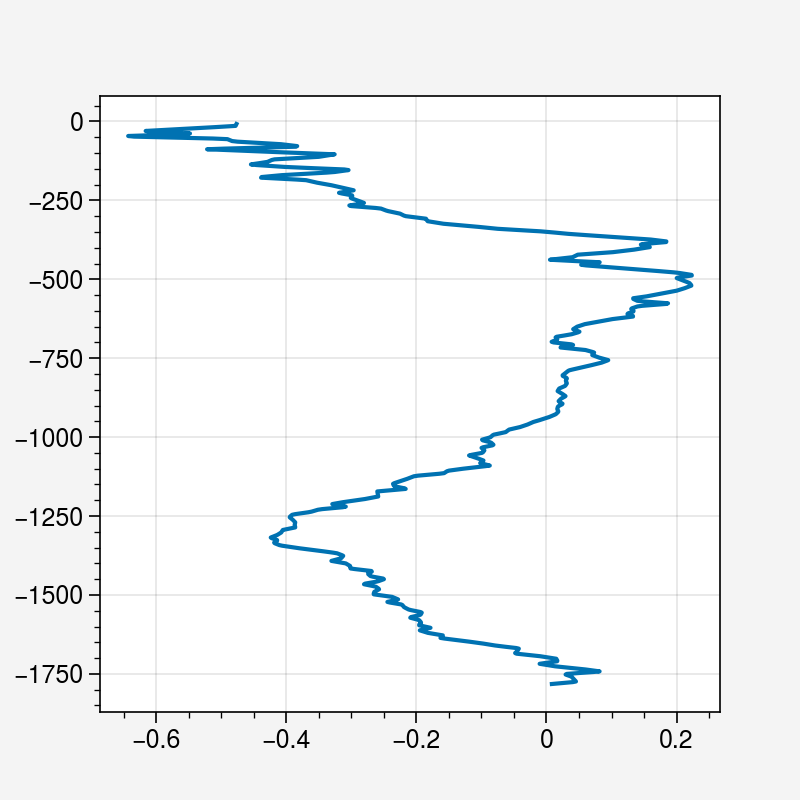

In [138]:
plt.plot(LADCP_cast_dataframe['Cast044']['v_int'],-LADCP_cast_dataframe['Cast044']['z_int'])

In [76]:
from scipy import stats as scipy_stats

#ctd_index_to_plot = [25,26,27]
ctd_index_to_plot = [29,28,30,31]
#ctd_index_to_plot = [7,6,8,9,10]
#ctd_index_to_plot = [5,11,16,14,13,12]
#ctd_index_to_plot = [5,11,16,14,13,12]

ctd_transect_lats = ctd_lats[ctd_index_to_plot]
ctd_transect_lons = ctd_lons[ctd_index_to_plot]
ctd_transect_times = ctd_times[ctd_index_to_plot]

ctd_transect_data = []

for i_ctd in ctd_index_to_plot:
    ctd_transect_data.append(xarray.open_dataset(os.path.join(ctd_datapath,ctd_files[i_ctd])) ) 


max_time = np.max(ctd_transect_times)
min_time = np.min(ctd_transect_times)



adcp_dataset_for_transect = adcp_dataset.sel(time=slice(min_time,max_time))

max_lat = adcp_dataset_for_transect['lat'].max()
max_lon = adcp_dataset_for_transect['lon'].max()

min_lat = adcp_dataset_for_transect['lat'].min()
min_lon = adcp_dataset_for_transect['lon'].min()


lon_grid = np.linspace(min_lon,max_lon,20)
lat_grid = np.linspace(min_lat,max_lat,20)



adcp_depth = adcp_dataset_for_transect['depth'][0,:]

u_binned = np.zeros([lon_grid.size,adcp_depth.size],dtype='float32')
v_binned = np.zeros([lon_grid.size,adcp_depth.size],dtype='float32')

distance_threshold = 1000.0

for i_point in range(0,lon_grid.size):
    distance_to_adcp = distance(adcp_dataset_for_transect['lat'].values, adcp_dataset_for_transect['lon'].values, lat_grid[i_point], lon_grid[i_point])
    idx_to_get = np.nonzero(distance_to_adcp<distance_threshold)[0]

    u_mean = np.nanmean(adcp_dataset_for_transect['u'][idx_to_get,:],axis=0)
    v_mean = np.nanmean(adcp_dataset_for_transect['v'][idx_to_get,:],axis=0)

    u_binned[i_point,:] = u_mean
    v_binned[i_point,:] = v_mean


/tmp/ipykernel_224687/1017021344.py:49: RuntimeWarning: Mean of empty slice
  u_mean = np.nanmean(adcp_dataset_for_transect['u'][idx_to_get,:],axis=0)
/tmp/ipykernel_224687/1017021344.py:50: RuntimeWarning: Mean of empty slice
  v_mean = np.nanmean(adcp_dataset_for_transect['v'][idx_to_get,:],axis=0)


In [8]:
ctd_transect_times

array([['2024-06-16T09:34:50.879003136'],
       ['2024-06-16T07:29:49.045000192'],
       ['2024-06-16T11:43:49.127997952'],
       ['2024-06-16T14:11:55.253999104']], dtype='datetime64[ns]')

In [ ]:
from scipy import stats as scipy_stats

#ctd_index_to_plot = [25,26,27]
#ctd_index_to_plot = [16,8,28,27]
ctd_index_to_plot = [7,6,8,9,10]




ctd_transect_lats = ctd_lats[ctd_index_to_plot]
ctd_transect_lons = ctd_lons[ctd_index_to_plot]

lat_segment = []
lon_segment = []



for i_point in range(1,len(ctd_index_to_plot)):
    lat_segment.append(np.linspace(ctd_transect_lats[i_point-1],ctd_transect_lats[i_point],10))
    lon_segment.append(np.linspace(ctd_transect_lons[i_point-1],ctd_transect_lons[i_point],10))

lat_segment = np.concatenate(lat_segment).squeeze()
lon_segment = np.concatenate(lon_segment).squeeze()

lat_segment = xarray.DataArray(lat_segment, dims="z")
lon_segment = xarray.DataArray(lon_segment, dims="z")

bathy_profile = bathy_dataset.interp(lat=lat_segment, lon=lon_segment)

ctd_transect_times = ctd_times[ctd_index_to_plot]

ctd_transect_data = []

for i_ctd in ctd_index_to_plot:
    ctd_transect_data.append(xarray.open_dataset(os.path.join(ctd_datapath,ctd_files[i_ctd])) ) 




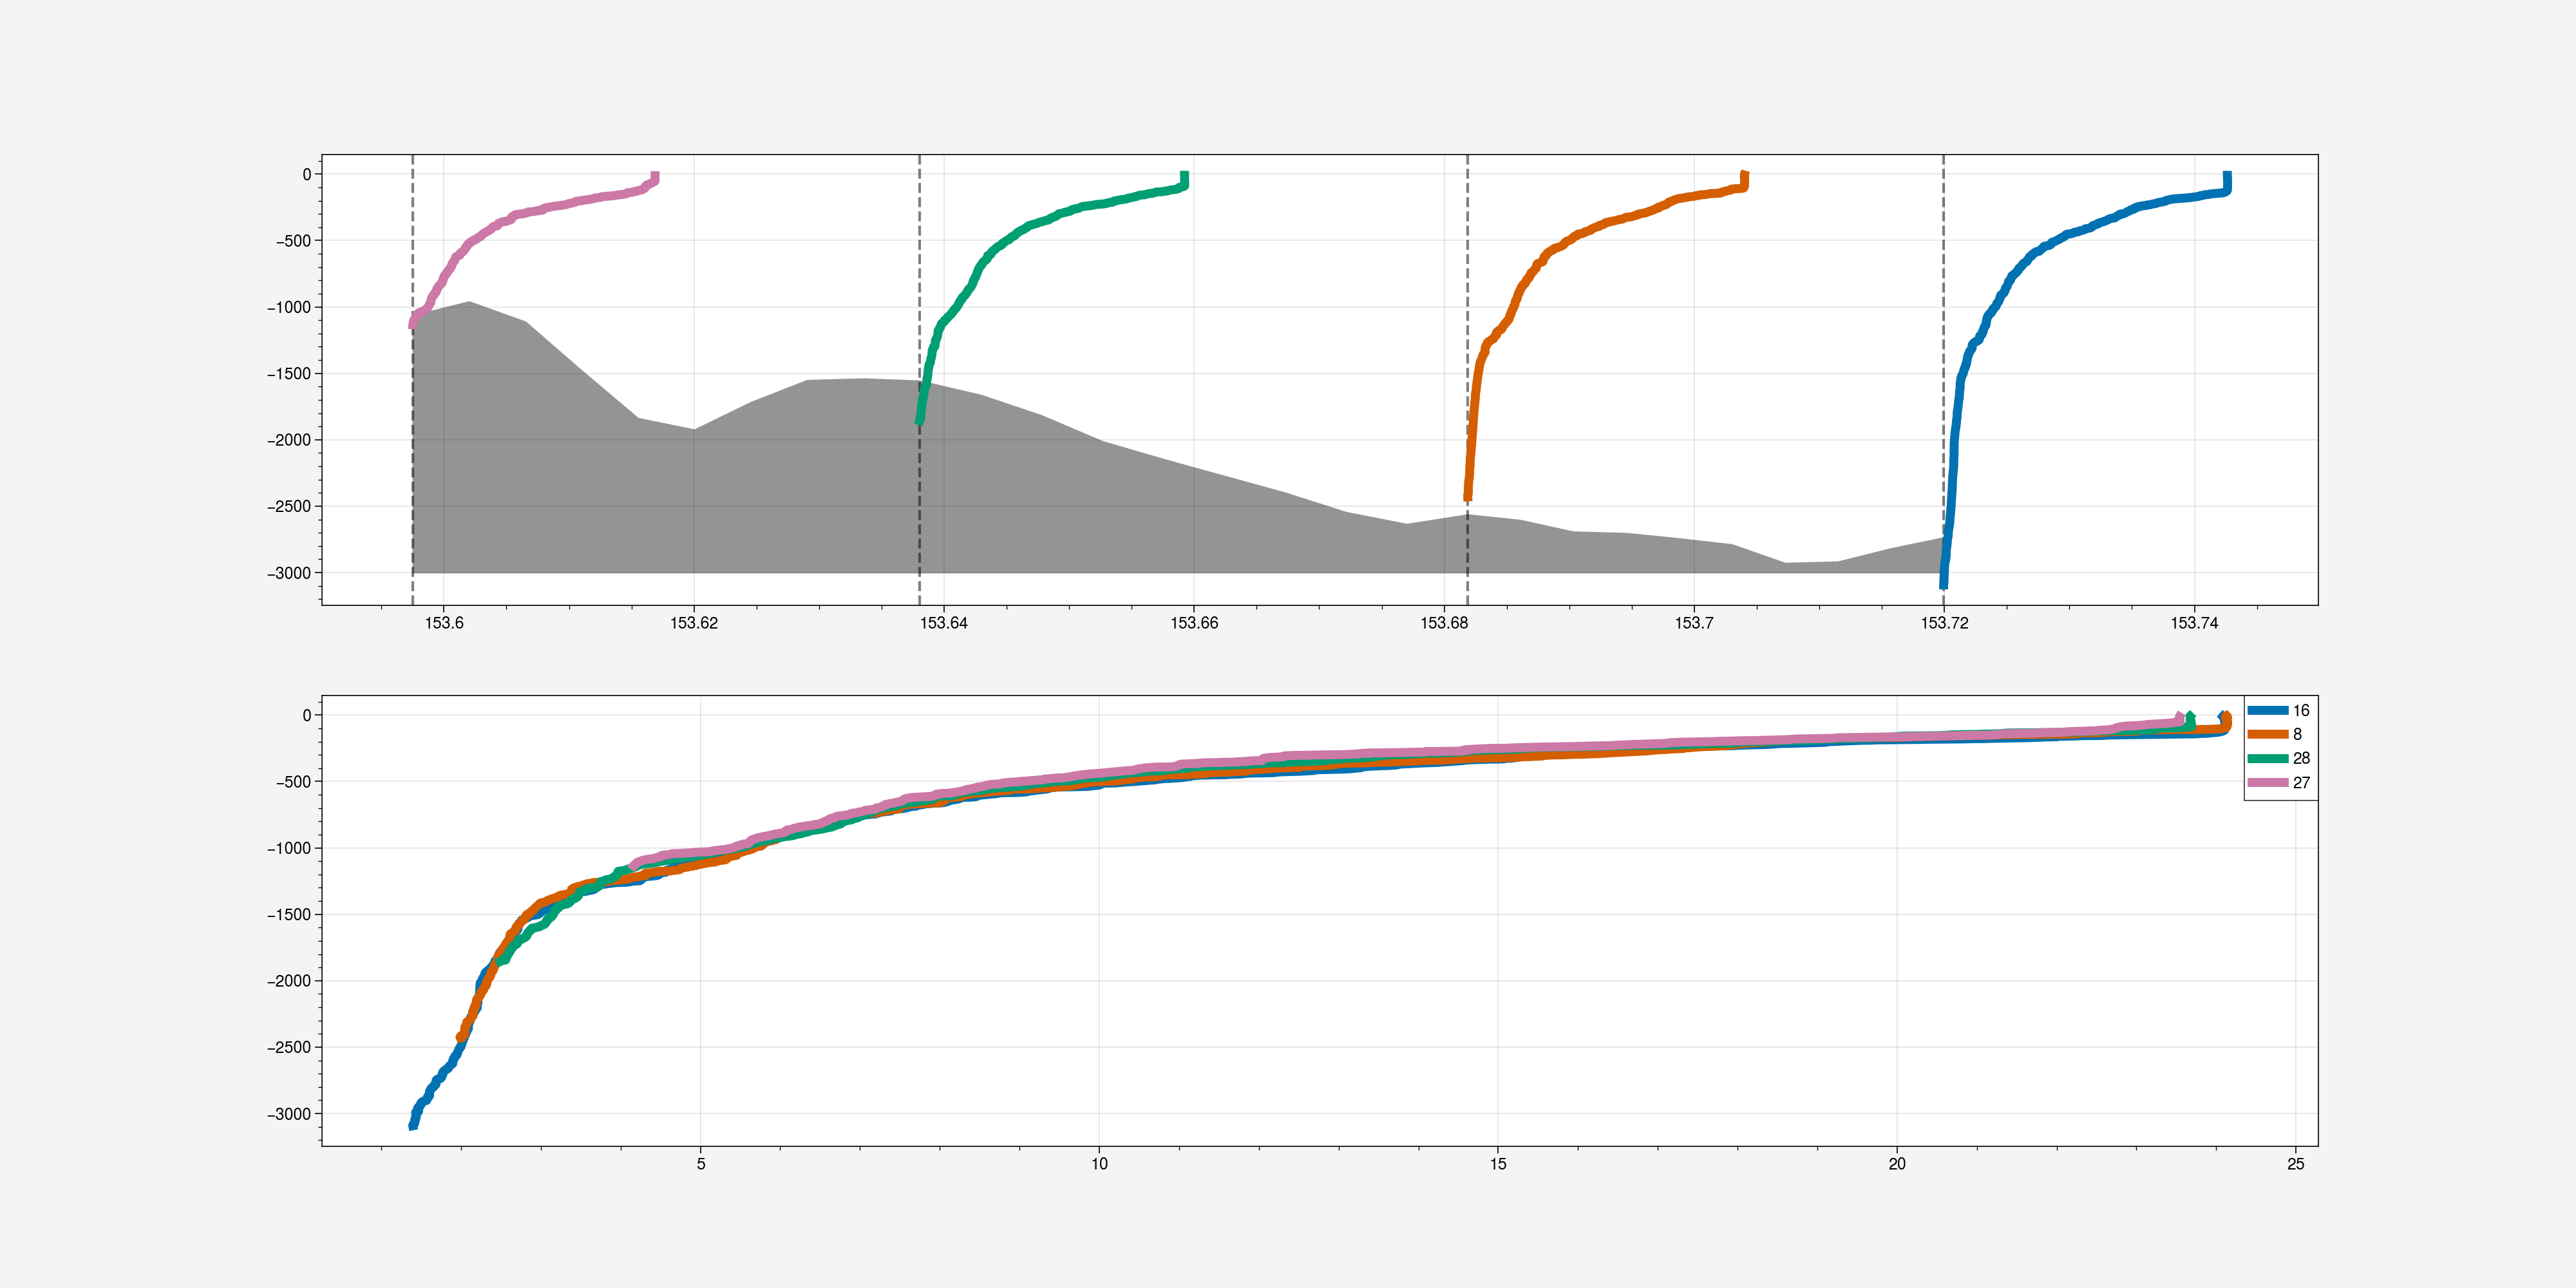

In [138]:
fig = plt.figure(1,figsize=(20,10))
ax =  fig.add_subplot(2,1,1)
ax.fill_between(lon_segment,bathy_profile['Band1'].values,-3000,color='grey')
for i_point in range(0,len(ctd_index_to_plot)):
    ax.axvline(x=ctd_lons[ctd_index_to_plot[i_point]],color='black',linestyle='--',alpha=0.5)
    temperature_profile = ctd_transect_data[i_point]['temperature'].squeeze()
    
    ax.plot(0.001*(temperature_profile-np.min(temperature_profile))+ctd_lons[ctd_index_to_plot[i_point]],-ctd_transect_data[i_point]['pressure'],
            label=ctd_index_to_plot[i_point],linewidth=5.0)
ax =  fig.add_subplot(2,1,2)
for i_point in range(0,len(ctd_index_to_plot)):
    temperature_profile = ctd_transect_data[i_point]['temperature'].squeeze()
    
    ax.plot(temperature_profile,-ctd_transect_data[i_point]['pressure'],
            label=ctd_index_to_plot[i_point],linewidth=5.0)
ax.legend()


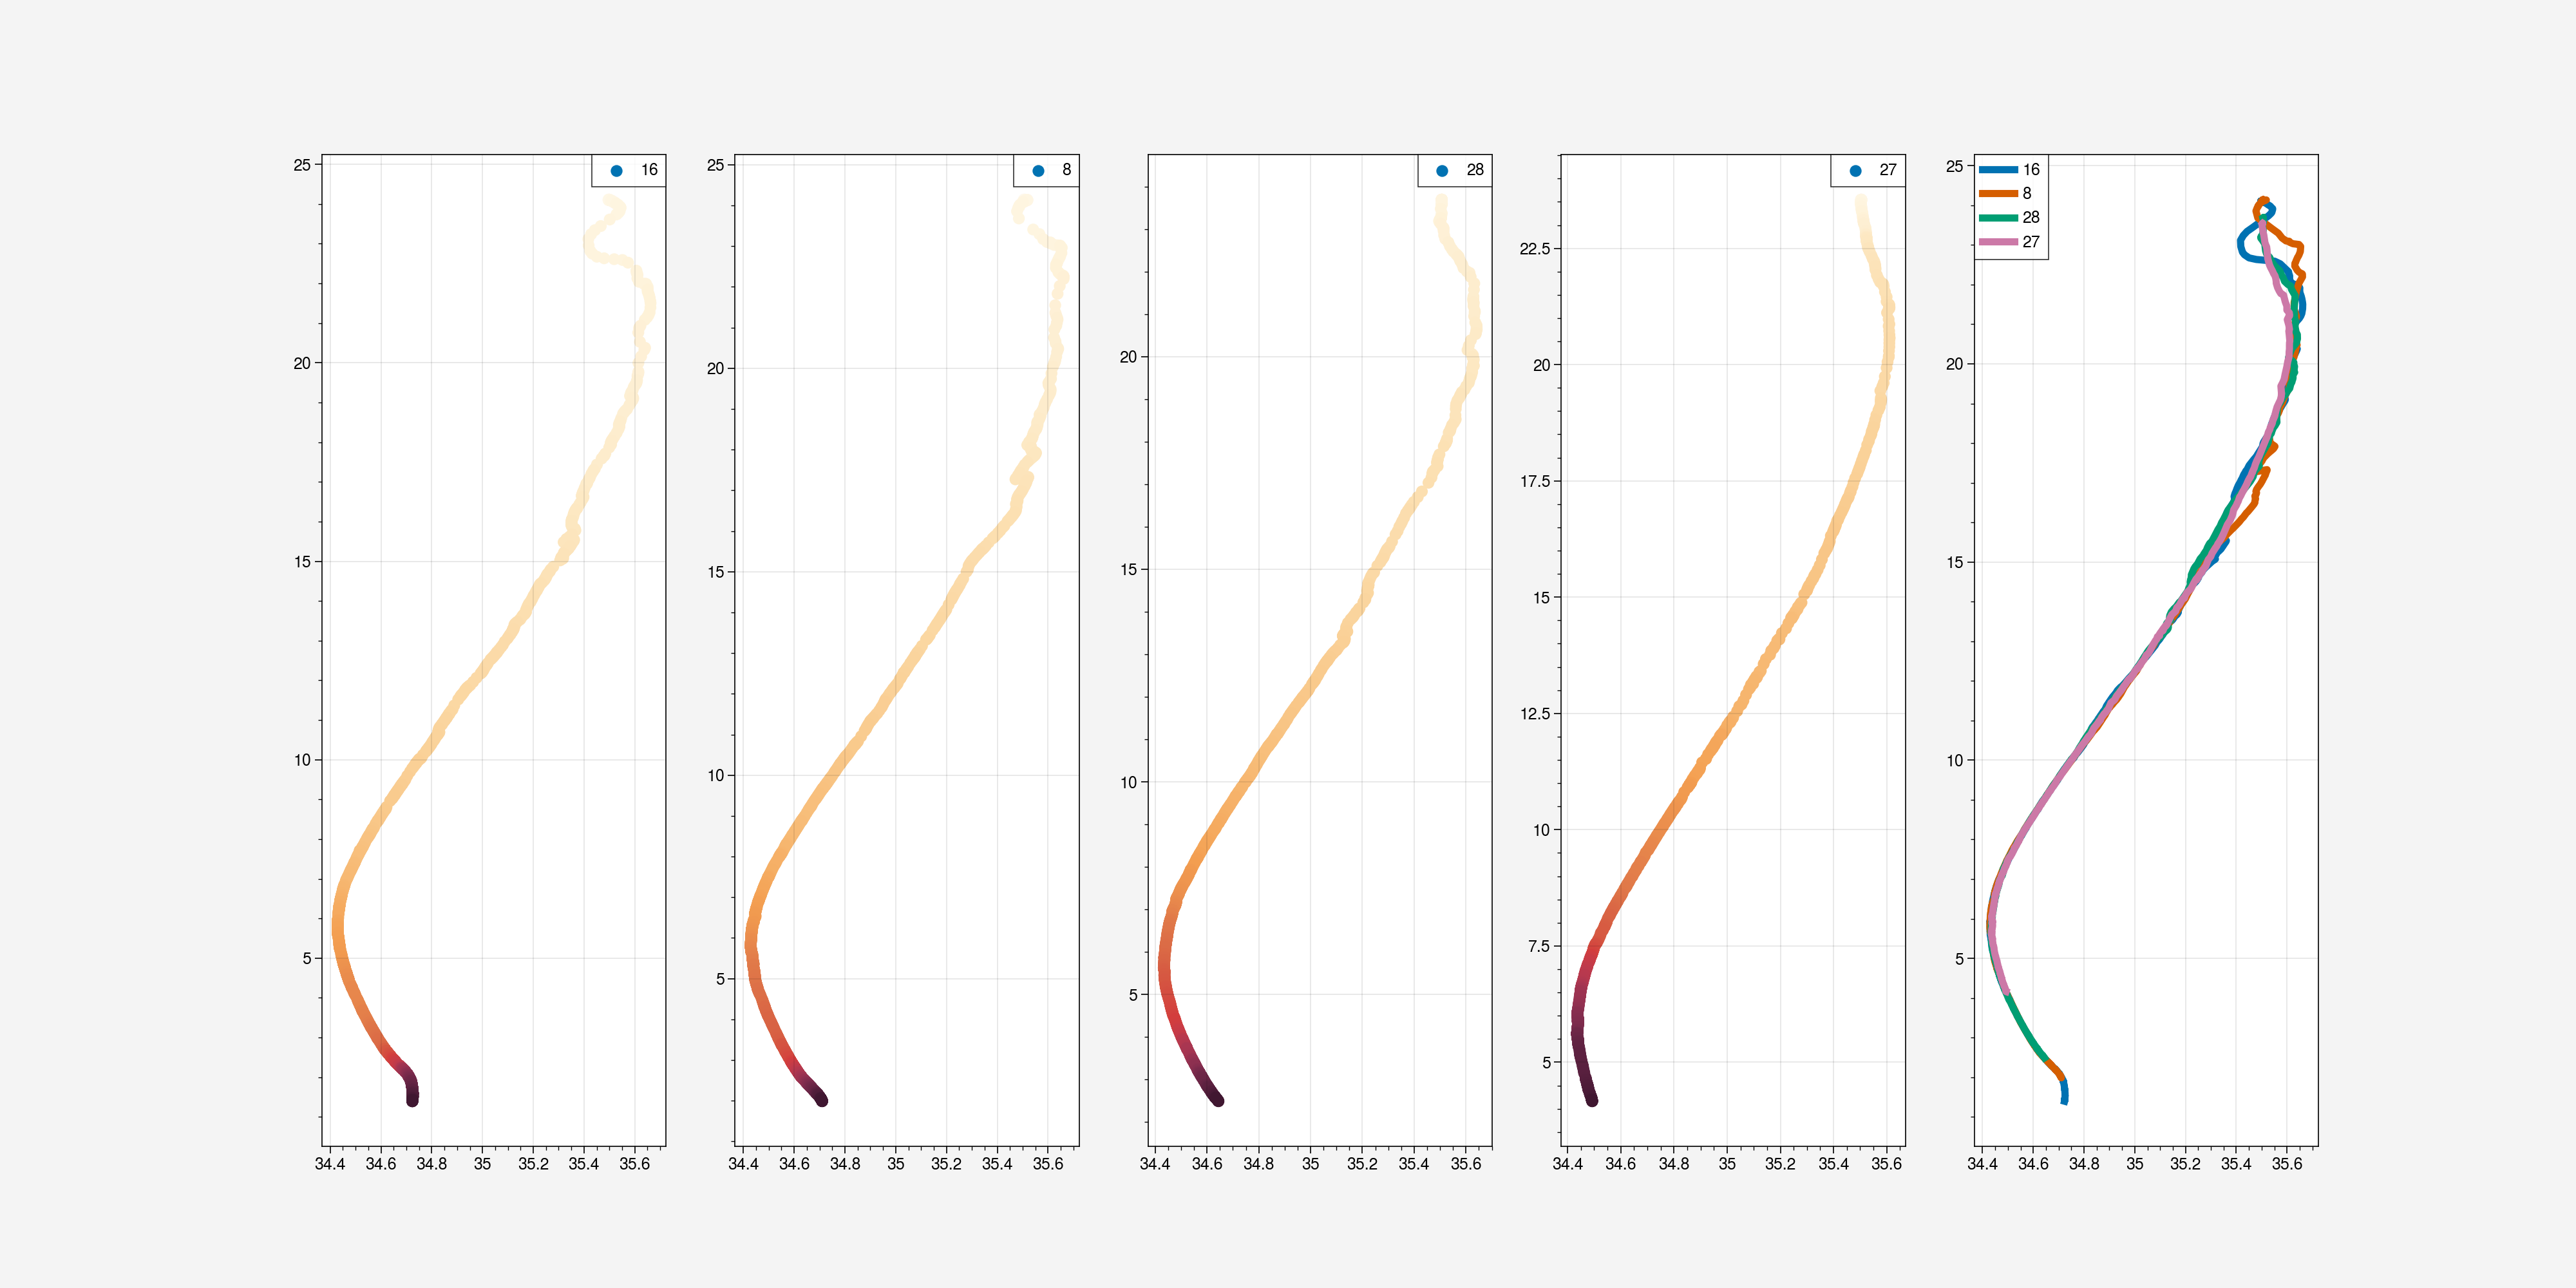

In [131]:
fig = plt.figure(1,figsize=(20,10))
#ax =  fig.add_subplot(1,1,1)

for i_point in range(0,len(ctd_index_to_plot)):

    ax =  fig.add_subplot(1,len(ctd_index_to_plot)+1,i_point+1)

    #ax.axvline(x=ctd_lons[ctd_index_to_plot[i_point]],color='black',linestyle='--')
    temperature_profile = ctd_transect_data[i_point]['temperature'].squeeze()
    salinity_profile    = ctd_transect_data[i_point]['salinity'].squeeze()
    pressure_profile    = ctd_transect_data[i_point]['pressure'].squeeze()

    ax.scatter(salinity_profile,temperature_profile,c=pressure_profile,label=ctd_index_to_plot[i_point])
    ax.legend()

ax =  fig.add_subplot(1,len(ctd_index_to_plot)+1,i_point+2)

for i_point in range(0,len(ctd_index_to_plot)):


    #ax.axvline(x=ctd_lons[ctd_index_to_plot[i_point]],color='black',linestyle='--')
    temperature_profile = ctd_transect_data[i_point]['temperature'].squeeze()
    salinity_profile    = ctd_transect_data[i_point]['salinity'].squeeze()
    pressure_profile    = ctd_transect_data[i_point]['pressure'].squeeze()

    ax.plot(salinity_profile,temperature_profile,label=ctd_index_to_plot[i_point],linewidth=4.0)
    ax.legend()


In [61]:
lat_segment.shape

(30, 1)

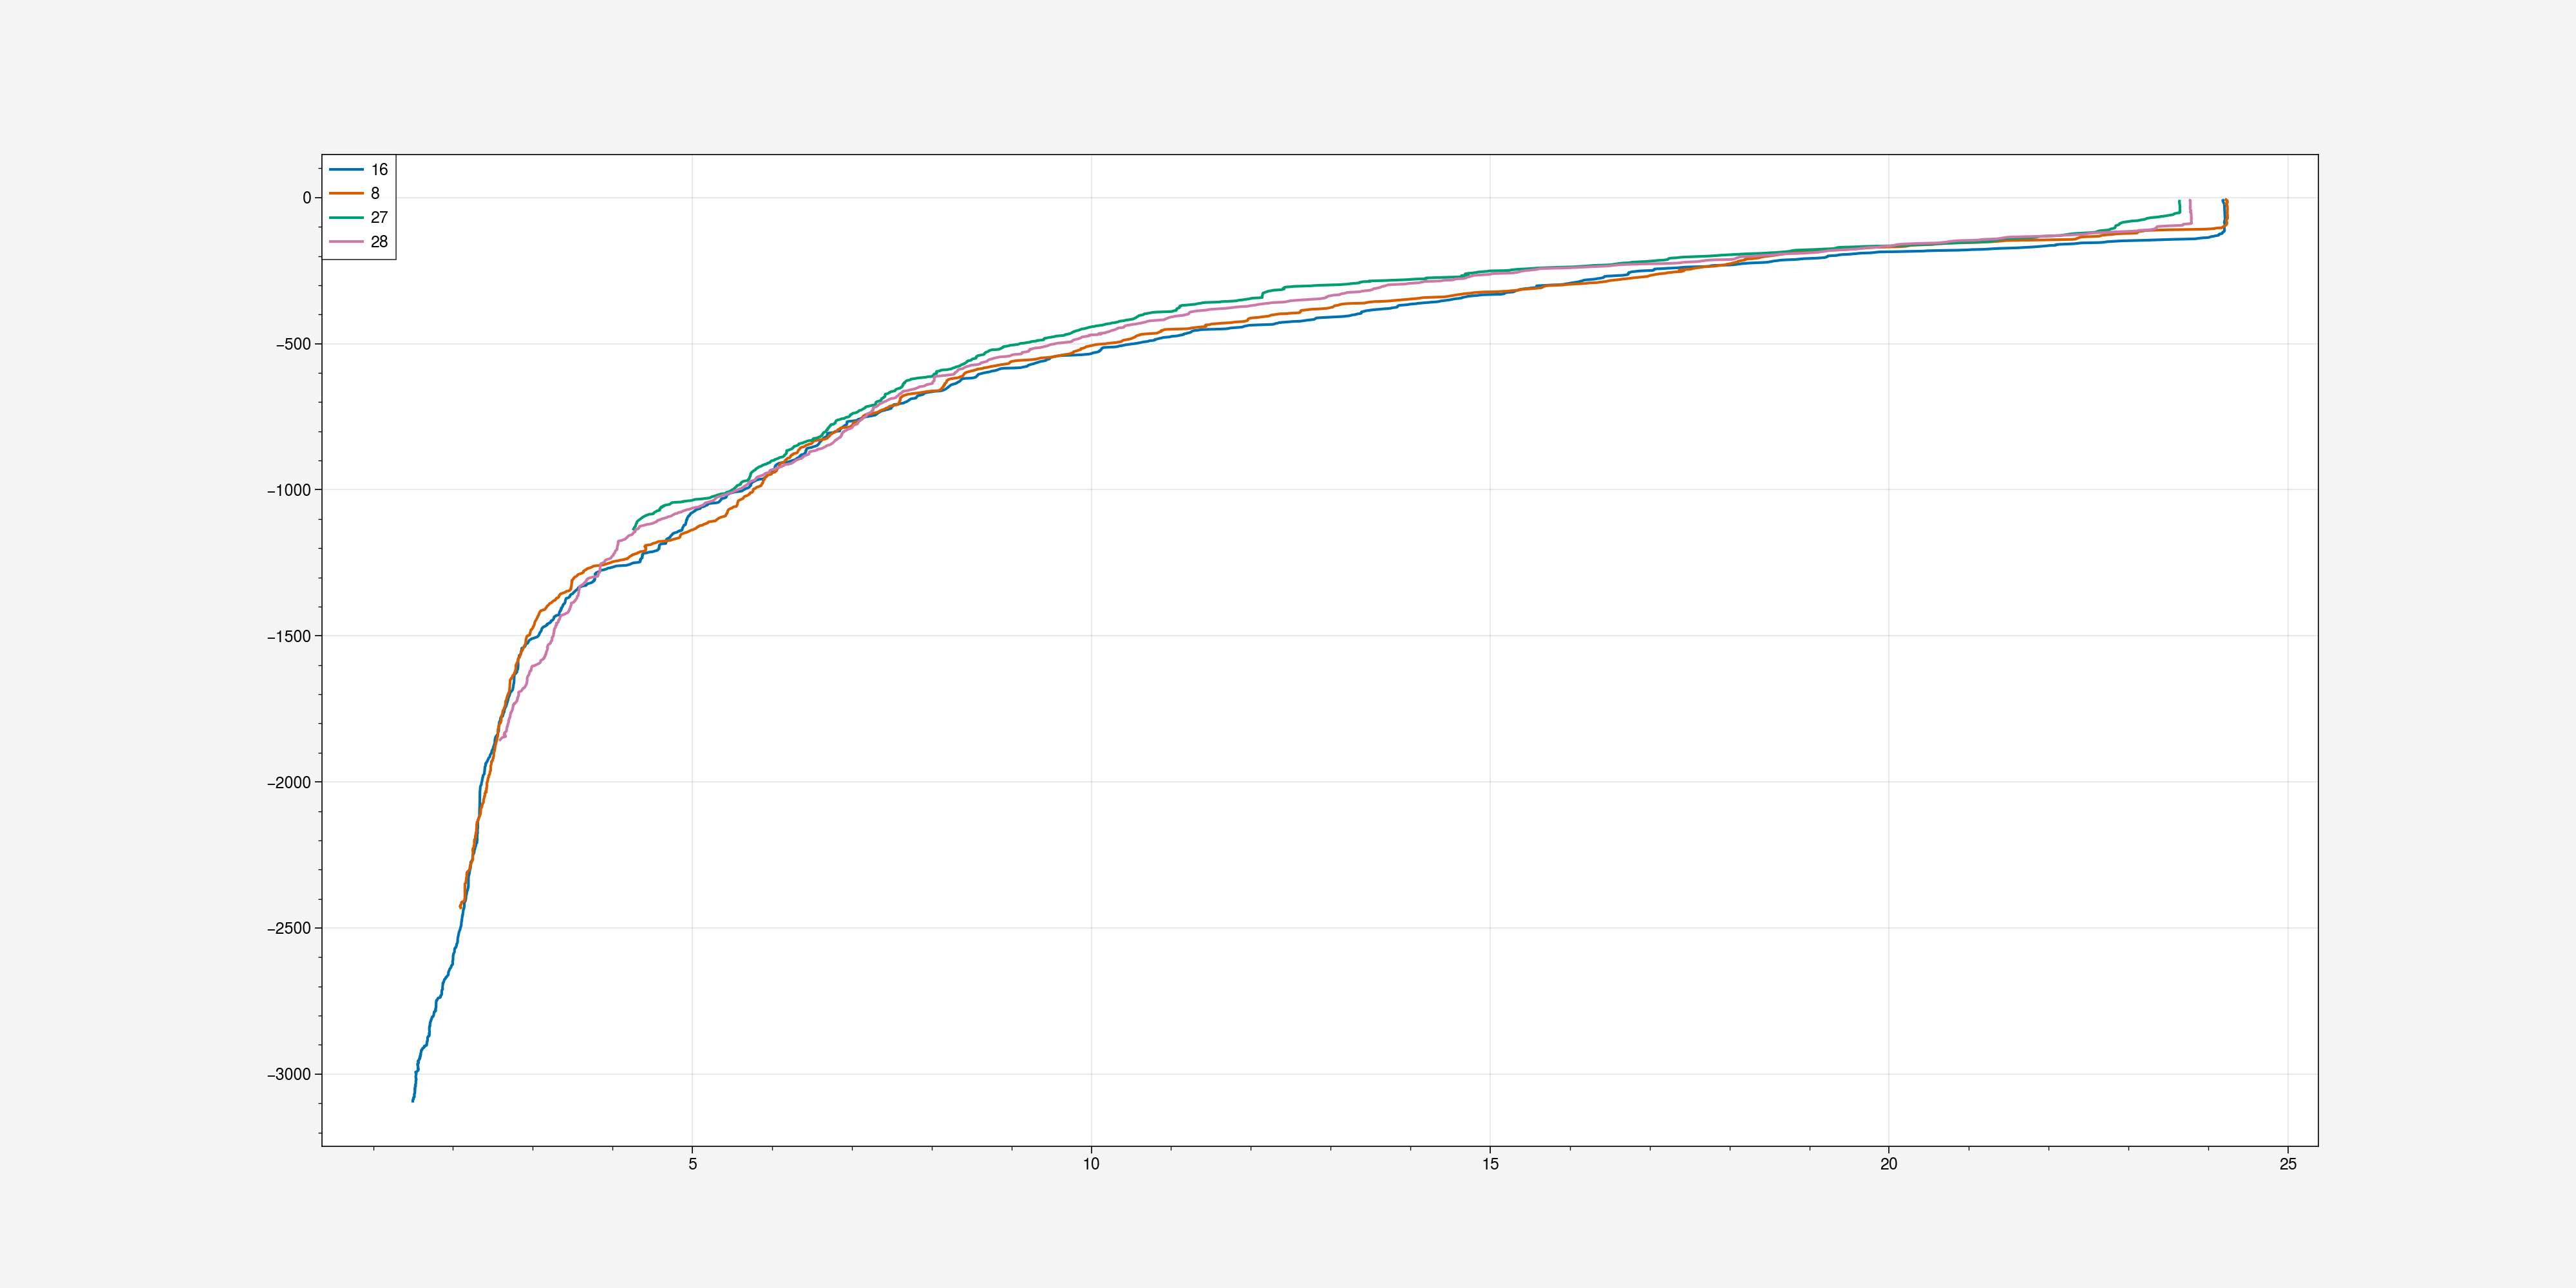

In [53]:

fig=plt.figure(1,figsize=(20,10))
ax = fig.add_subplot(1,1,1)
cast_counter = 0
for i_cast in ctd_transect_data:

    
    ax.plot(i_cast['temperature'].squeeze()+0.1,-i_cast['pressure'],label=ctd_index_to_plot[cast_counter])
    cast_counter = cast_counter+1
ax.legend(loc='upper left')

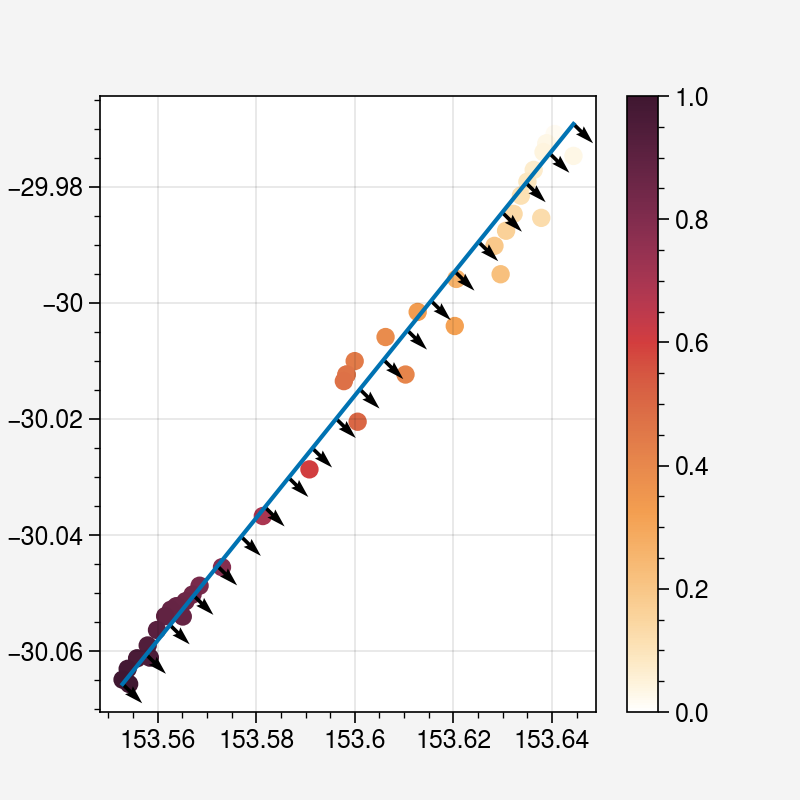

In [137]:
cs = plt.scatter(adcp_dataset_for_transect['lon'],adcp_dataset_for_transect['lat'],c=distance_to_adcp)
plt.plot(lon_grid,lat_grid)
plt.quiver(lon_grid,lat_grid,normal_x,normal_y)
plt.colorbar()

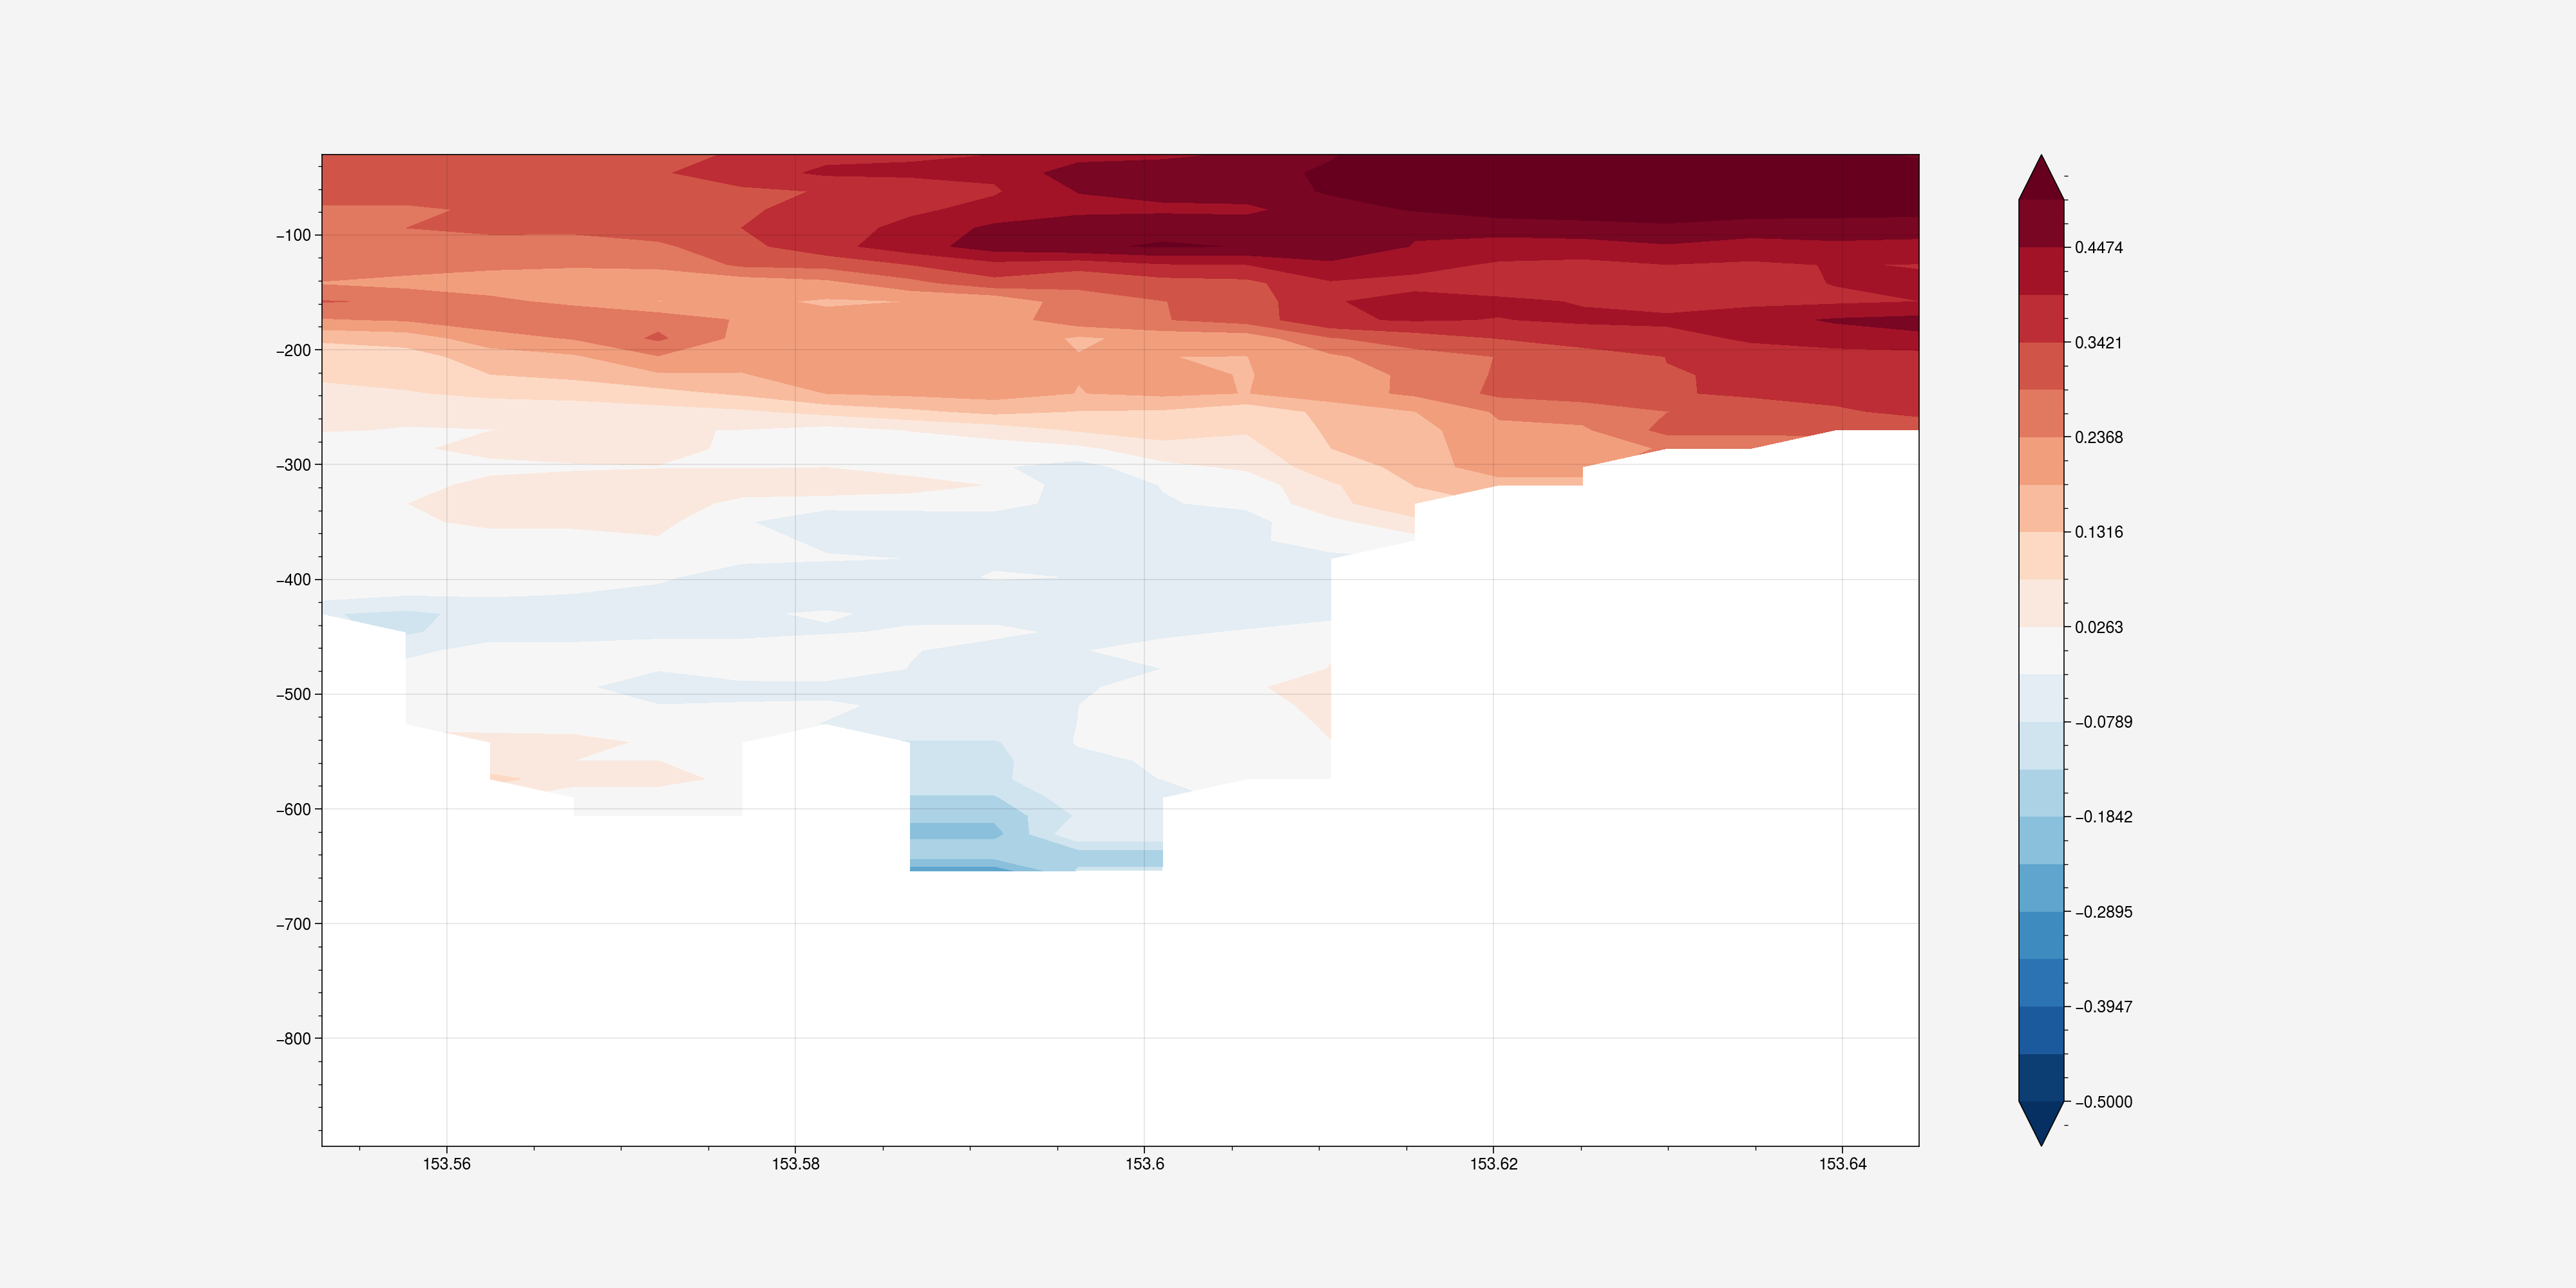

In [138]:
tangent_vector = np.asarray([np.diff(lon_grid),np.diff(lat_grid)]) 
tangent_vector = tangent_vector / np.sqrt(tangent_vector[0,:]*tangent_vector[0,:] + tangent_vector[1,:]*tangent_vector[1,:])

tangent_vector = np.hstack([tangent_vector[:,0][:,np.newaxis],tangent_vector ]) #,axis=0)

normal_x =  tangent_vector[1,:]
normal_y = -tangent_vector[0,:]



normal_velocity  = normal_x[:,np.newaxis]*u_binned + normal_y[:,np.newaxis]*v_binned

plt.figure(1,figsize=(20,10))
plt.contourf(lon_grid,-adcp_depth,normal_velocity.T,np.linspace(-0.50,0.50,20),cmap='RdBu_r',extend='both')
plt.colorbar()


In [79]:
tangent_vector

array([[0.00466126, 0.00466126, 0.00466126, 0.00466126, 0.00466126,
        0.00466126, 0.00466126, 0.00466126, 0.00466126, 0.00466126,
        0.00466126, 0.00466126, 0.00466126, 0.00466126, 0.00466126,
        0.00466126, 0.00466126, 0.00466126, 0.00466126],
       [0.00475102, 0.00475102, 0.00475102, 0.00475102, 0.00475102,
        0.00475102, 0.00475102, 0.00475102, 0.00475102, 0.00475102,
        0.00475102, 0.00475102, 0.00475102, 0.00475102, 0.00475102,
        0.00475102, 0.00475102, 0.00475102, 0.00475102]])

In [77]:
adcp_dataset_for_transect.time

<xarray.DataArray 'time' (time: 42)>
array(['2024-06-15T23:46:33.000000000', '2024-06-15T23:51:33.000000000',
       '2024-06-15T23:56:33.000000000', '2024-06-16T00:01:32.000000000',
       '2024-06-16T00:06:32.000000000', '2024-06-16T00:11:33.000000002',
       '2024-06-16T00:16:33.000000000', '2024-06-16T00:21:33.000000000',
       '2024-06-16T00:26:33.000000000', '2024-06-16T00:31:32.000000000',
       '2024-06-16T00:36:33.000000000', '2024-06-16T00:41:33.000000000',
       '2024-06-16T00:46:33.000000000', '2024-06-16T00:51:33.000000000',
       '2024-06-16T00:56:33.000000002', '2024-06-16T01:01:33.000000000',
       '2024-06-16T01:06:33.000000000', '2024-06-16T01:11:33.000000000',
       '2024-06-16T01:16:33.000000000', '2024-06-16T01:21:33.000000000',
       '2024-06-16T01:26:33.000000000', '2024-06-16T01:31:32.000000000',
       '2024-06-16T01:36:33.000000000', '2024-06-16T01:41:33.000000002',
       '2024-06-16T01:46:31.999999998', '2024-06-16T01:51:32.000000000',
       '2024-06-16T01:56:33.000000000', '2024-06-16T02:01:33.000000000',
       '2024-06-16T02:06:33.000000000', '2024-06-16T02:11:32.000000000',
       '2024-06-16T02:16:33.000000000', '2024-06-16T02:21:33.000000000',
       '2024-06-16T02:26:33.000000002', '2024-06-16T02:31:33.000000000',
       '2024-06-16T02:36:33.000000000', '2024-06-16T02:41:33.000000000',
       '2024-06-16T02:46:33.000000000', '2024-06-16T02:51:33.000000000',
       '2024-06-16T02:56:33.000000000', '2024-06-16T03:01:32.000000000',
       '2024-06-16T03:06:33.000000000', '2024-06-16T03:11:32.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2024-06-15T23:46:33 ... 2024-06-16T03:11:32
Attributes:
    long_name:      Decimal day
    C_format:       %12.5f
    standard_name:  time
    axis:           T
    data_min:       164.8251273148148
    data_max:       170.30916666666667

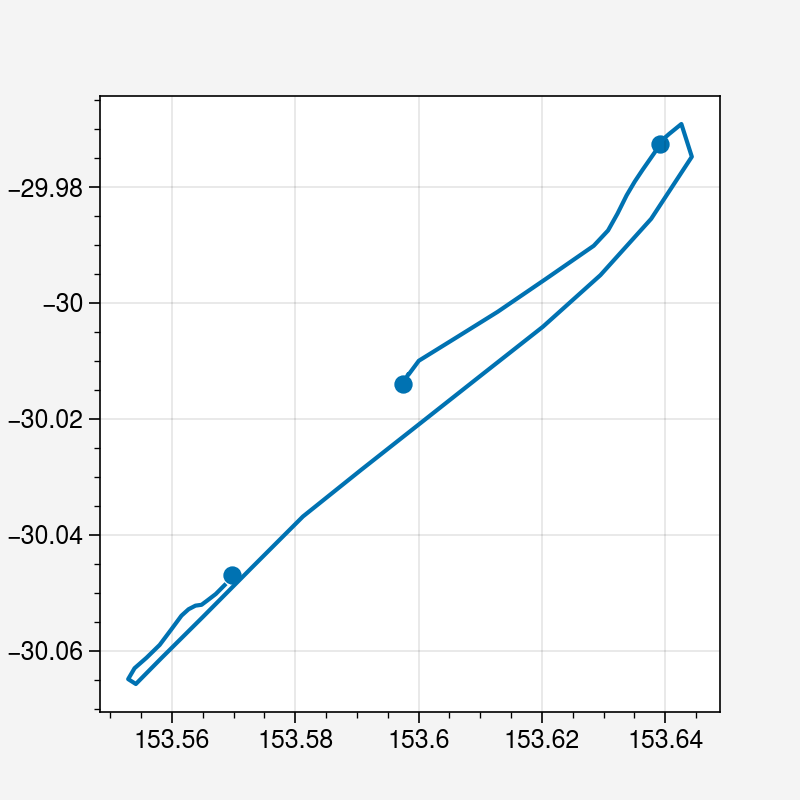

In [39]:
plt.plot(adcp_dataset_for_transect['lon'],adcp_dataset_for_transect['lat'])
plt.scatter(ctd_transect_lons,ctd_transect_lats)

In [41]:
min_time

numpy.datetime64('2024-06-15T23:43:07.421002240')

In [42]:
max_time

numpy.datetime64('2024-06-16T03:13:05.255004672')